# Project 3 - Thermal inspection (classifying the defects) of photovoltaic modules

## Assignment 2 (preliminary delivery)

**Computer Vision**

Master in Data Science and Engineering - Faculdade de Engenharia da Universidade do Porto


Cátia Teixeira (200808037) |  Miguel Veloso (202202463)



---



## Introduction

The following classes are present in our dataset:



1.  **Cell Module**: a hot spot that appears in a single cell
2.   **Cell-Multi Module**: one of the hot spots in multiple cells
3.   **Cracking**: appeared on the surface of the module in single or multiple long-curve
4.    **Diode module**: activated bypass diode in about 1/3 area of the
module, which looks like a straight line in the IR image
5.   **Diode-Multi module**: activated bypass diode in about 2/3 area of the module
6.   **Hot-Spot module**: hot-spot in a thin film module
7. **Hot-Spot-Multi module**: multiple hot-spot in the thin-film module
8. **Offline module**: s heated entire the module (which looks like the No-anomaly module)
9. **Shadowing module**: blocked by vegetation or manmade structure
10. **Vegetation module**: blocked by vegetation (which is similar to the Shadowing module)
11. **Soiling module**: dirt or dust on the surface of the module (which looks like the Cell or Vegetation modules in the IR image)
12. **No-anomaly module**: Nominal solar module









---



## Methodology

The following steps were not completed at the moment due to resource/time restrictions.

* Several sections of the report need to be completed (Introduction,conclusions, etc)
* Condition D is yet to be implemented.
* Pre-trained ResNET and pre-trained Transformer nedds additinal tunning and further implementation. 

In the following diagram we can see the proposed plan for this project.

<center><img src="flow.drawio.png"/></center>

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision
from torchinfo import summary
from torch.optim import Adam, SGD
import cv2
import numpy as np
from PIL import Image
import torch_optimizer as t_optim

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print ("Device is:", device)

Device is: cuda


In [3]:
import utils

In [4]:
import scprep
scprep.io.download.download_and_extract_zip(
   url="https://github.com/RaptorMaps/InfraredSolarModules/raw/master/2020-02-14_InfraredSolarModules.zip",
   destination=".")

In [4]:
metadata_path = "../InfraredSolarModules/module_metadata.json"
images_path = "../InfraredSolarModules/"
solar_dataset = utils.SolarDataset(metadata_path, images_path, random_state=42)

(20000, 2)


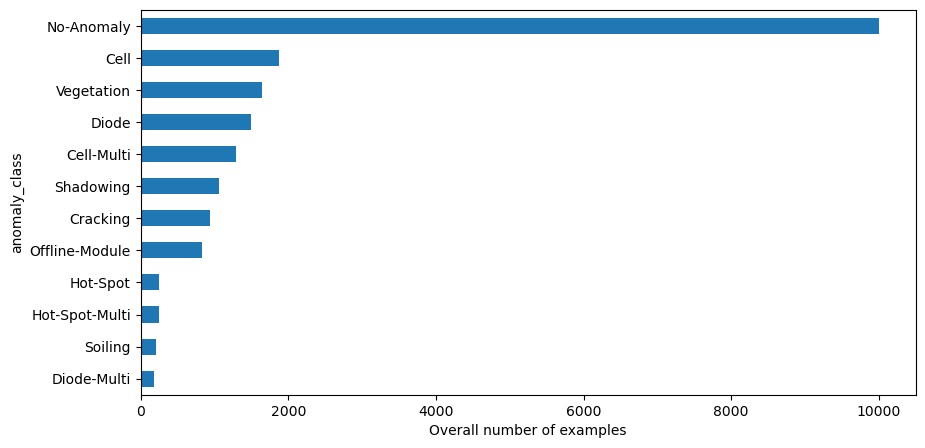

(12801, 2)


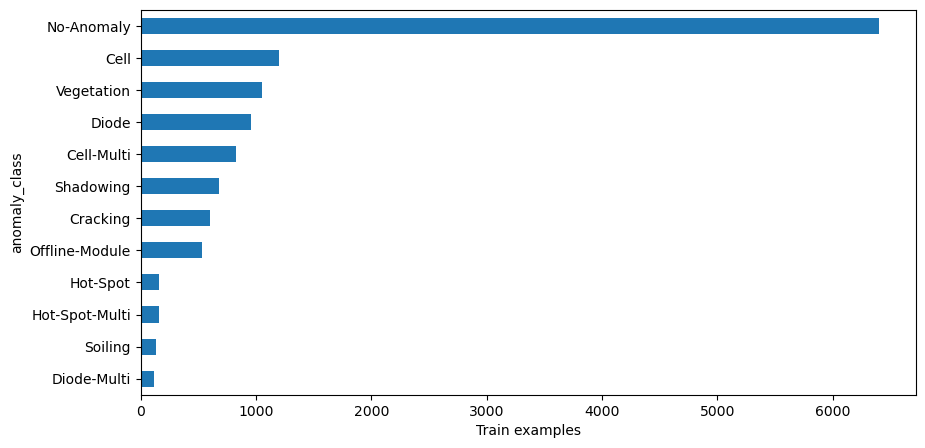

(3199, 2)


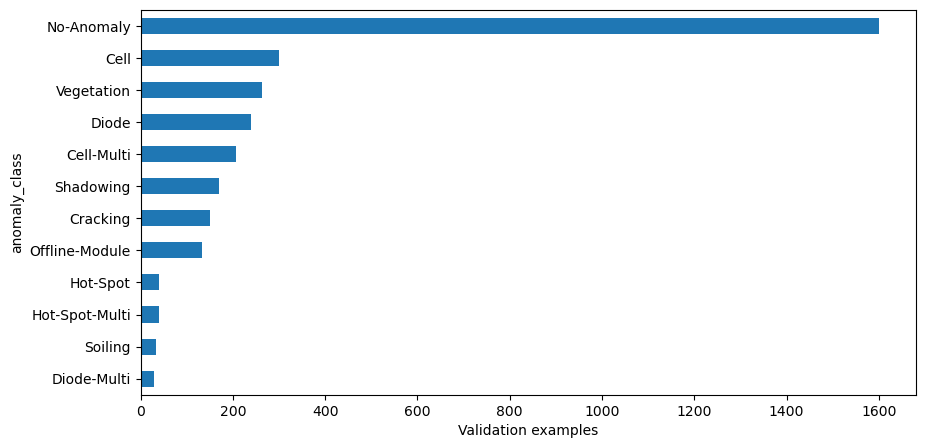

(4000, 2)


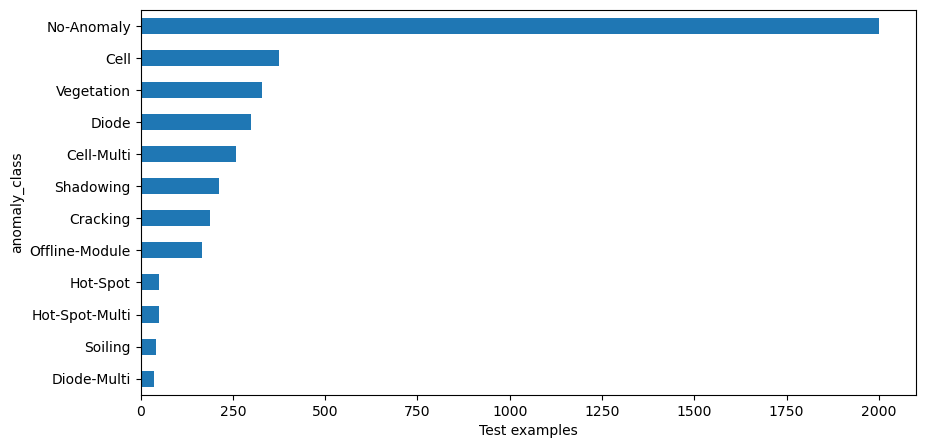

In [5]:
dfs_to_show = [
    [solar_dataset.full_df, "Overall number of examples"],
    [solar_dataset.train_df, "Train examples"],
    [solar_dataset.val_df, "Validation examples"],
    [solar_dataset.test_df, "Test examples"],
]

for (d, t) in dfs_to_show:
    ax = d.anomaly_class.value_counts().sort_values(ascending=True).plot.barh(figsize=(10,5))
    ax.set_xlabel(t)
    print(d.shape)
    plt.show()

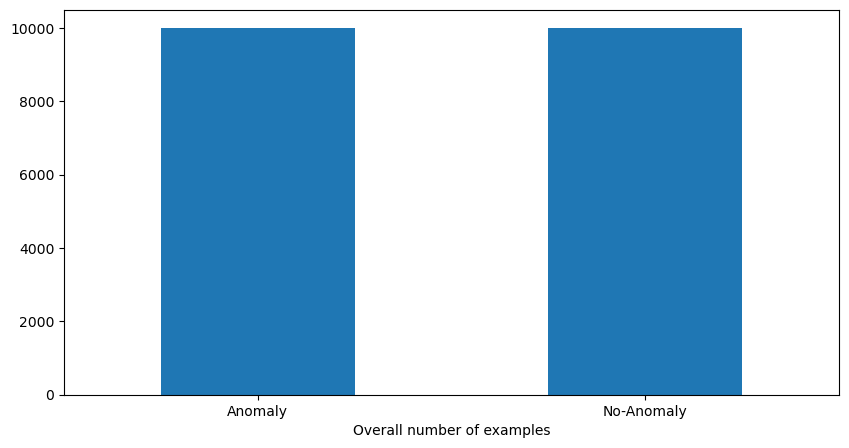

In [6]:
def convert_to_binary(x):
    x = 'Anomaly' if x != 'No-Anomaly' else x
    return x

df_binary = solar_dataset.full_df.copy()
df_binary['anomaly_class'] = solar_dataset.full_df.anomaly_class.apply(convert_to_binary)
ax = df_binary['anomaly_class'].value_counts().plot.bar(figsize=(10,5))
ax.tick_params(labelrotation=0)
ax.set_xlabel('Overall number of examples')
plt.show()

# Basic Pre-Processing

In [7]:
def preprocess_none(image, aug_number=0, label=None):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image[np.newaxis]
    return [image]

In [8]:
def preprocess_basic(image, aug_number=0, label=None):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = (image - 127.5) / 127.5
    image = image[np.newaxis]
    return [image]

# Defining Model from Paper

In [9]:
class PaperClassificator(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.model = nn.Sequential(
            # BLock 1
            nn.Conv2d(in_dim[0], 80, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(80),
            # Block 2
            nn.Conv2d(80, 160, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(160),
            # Block 3
            nn.Conv2d(160, 320, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(320),
            # Block 4
            nn.Conv2d(320, 640, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(1, 2),
            nn.BatchNorm2d(640),
            # Average Pool
            nn.AvgPool2d(2),
            # Fully connected
            nn.Flatten(),
            nn.Linear(640, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        return self.model(x)

## Running model from paper

In [10]:
input_dim = (1, 40, 24)
output_dim = solar_dataset.num_classes
paper_model = PaperClassificator(input_dim, output_dim).to(device)
print(summary(paper_model, (1, input_dim[0], input_dim[1], input_dim[2])))
paper_loss = torch.nn.CrossEntropyLoss()
paper_optimizer = Adam(paper_model.parameters(), lr=0.0003)
paper_train_test = utils.TrainTest(
    paper_model,
    paper_loss,
    64,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_none,
)

Layer (type:depth-idx)                   Output Shape              Param #
PaperClassificator                       [1, 12]                   --
├─Sequential: 1-1                        [1, 12]                   --
│    └─Conv2d: 2-1                       [1, 80, 40, 24]           800
│    └─ReLU: 2-2                         [1, 80, 40, 24]           --
│    └─MaxPool2d: 2-3                    [1, 80, 20, 12]           --
│    └─BatchNorm2d: 2-4                  [1, 80, 20, 12]           160
│    └─Conv2d: 2-5                       [1, 160, 20, 12]          115,360
│    └─ReLU: 2-6                         [1, 160, 20, 12]          --
│    └─MaxPool2d: 2-7                    [1, 160, 10, 6]           --
│    └─BatchNorm2d: 2-8                  [1, 160, 10, 6]           320
│    └─Conv2d: 2-9                       [1, 320, 10, 6]           461,120
│    └─ReLU: 2-10                        [1, 320, 10, 6]           --
│    └─MaxPool2d: 2-11                   [1, 320, 5, 3]            --
│ 

c:\ProgramData\anaconda3\Lib\site-packages\torch\autograd\__init__.py:251: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\engine.cpp:1176.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Best Epoch # 0  Validation Loss= 2.002531051635742  Validation Accu= 0.6170678336980306
Best Epoch # 1  Validation Loss= 1.9724626541137695  Validation Accu= 0.6486402000625195
Best Epoch # 3  Validation Loss= 1.9403690099716187  Validation Accu= 0.6780243826195687
Best Epoch # 4  Validation Loss= 1.9382274150848389  Validation Accu= 0.6798999687402313
Best Epoch # 5  Validation Loss= 1.930090069770813  Validation Accu= 0.6886527039699907
Best Epoch # 6  Validation Loss= 1.9159741401672363  Validation Accu= 0.7030321975617381
Best Epoch # 10  Validation Loss= 1.9127565622329712  Validation Accu= 0.7039699906220694
Best Epoch # 12  Validation Loss= 1.9130722284317017  Validation Accu= 0.7045951859956237
Best Epoch # 13  Validation Loss= 1.9079842567443848  Validation Accu= 0.7099093466708346
Best Epoch # 14  Validation Loss= 1.8974875211715698  Validation Accu= 0.721475461081588
Best Epoch # 15  Validation Loss= 1.8968586921691895  Validation Accu= 0.7217880587683652
Best Epoch # 16  Va

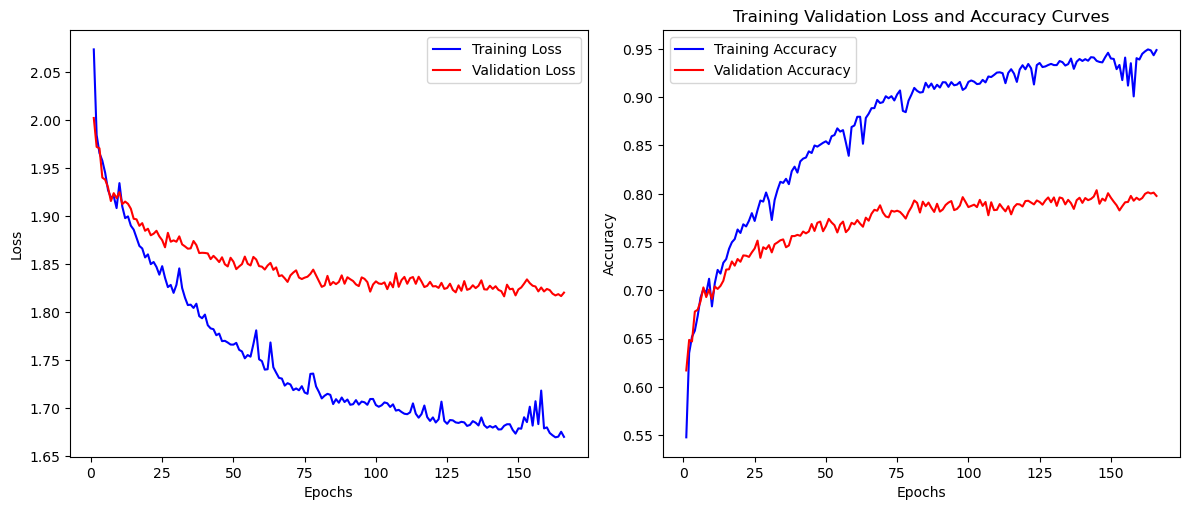

In [11]:
# Train Model
paper_best_loss, paper_best_accuracy, paper_best_epoch = paper_train_test.train(paper_optimizer, 166, "paper_model.pth")

Loss = 1.8291053677362108   Accuracy= 0.7896825396825397


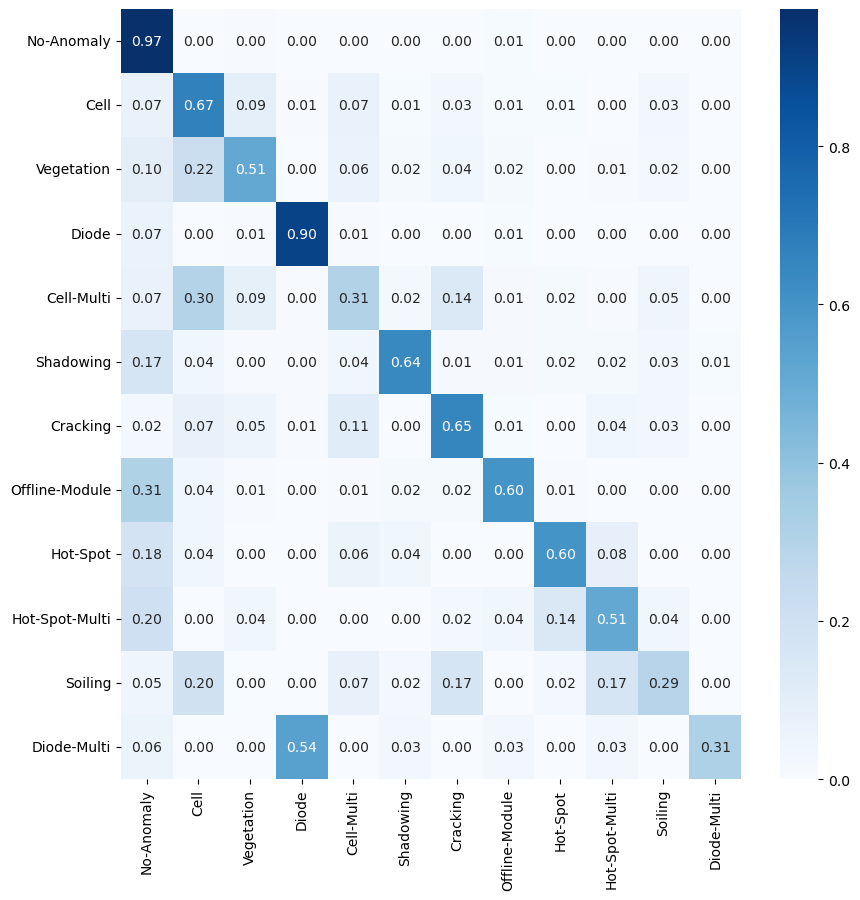

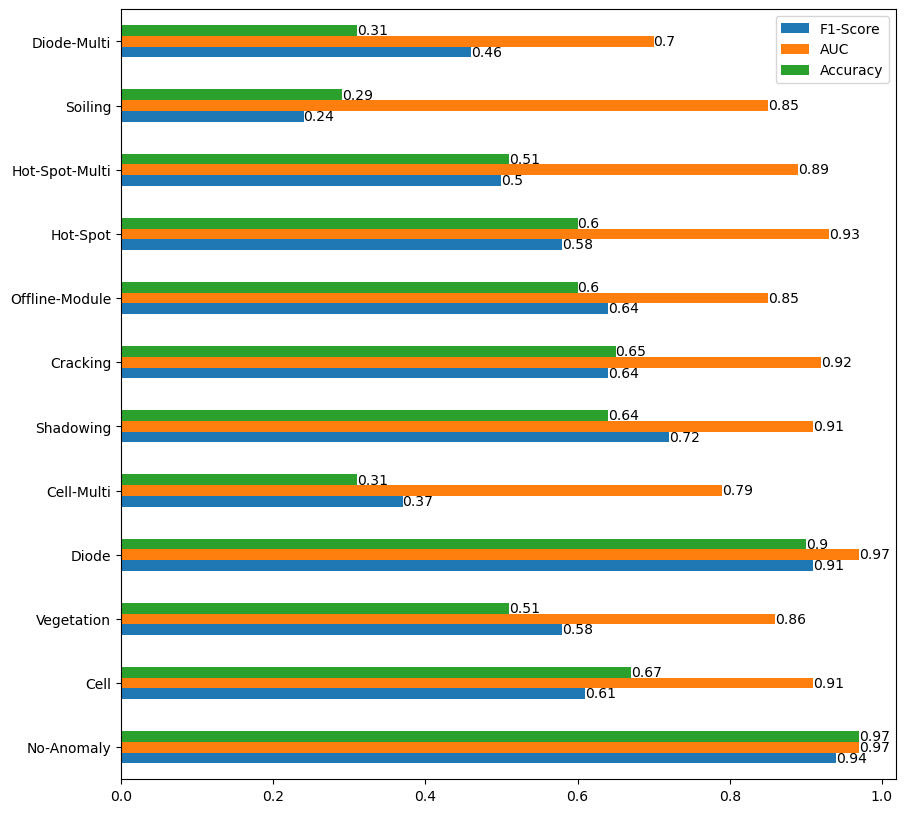

In [12]:
paper_train_test.test()
paper_train_test.plot_confusion_matrix()
paper_train_test.plot_class_metrics()

---

# Defining our CNN model

In [68]:
class OurClassificatorImp(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_dim[0], 20, 4, 2, 1),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout(0.30),
            # Input is Zx20x12
            nn.Conv2d(20, 40, 4, 2, 1),
            nn.BatchNorm2d(40),
            nn.ReLU(),
            nn.Dropout(0.30),
            # Input is Zx10x6
            nn.Conv2d(40, 80, 4, 2, 1),
            nn.BatchNorm2d(80),
            nn.ReLU(),
            nn.Dropout(0.30),
            # Input is Zx10x6
            nn.Conv2d(80, 160, 3, 1, 1),
            nn.BatchNorm2d(160),
            nn.ReLU(),
            nn.Dropout(0.30),
            # Input is Zx5x3
            nn.Conv2d(160, 320, (5, 3), 1, 0),
            nn.BatchNorm2d(320),
            nn.ReLU(),
            nn.Dropout(0.50),
            nn.Flatten(),
            nn.Linear(320, 110),
            nn.ReLU(),
            nn.Dropout(0.70),
            nn.Linear(110, out_dim),
            #nn.Sigmoid(),
            #nn.Softmax(dim=-1),
        )

    def forward(self, x):
        return self.model(x)

In [71]:
input_dim = (1, 40, 24)
output_dim = solar_dataset.num_classes
our_model = OurClassificatorImp(input_dim, output_dim).to(device)
print(summary(our_model, (1, input_dim[0], input_dim[1], input_dim[2])))
our_loss = nn.BCEWithLogitsLoss()
#our_loss = nn.BCELoss()
#our_loss = nn.CrossEntropyLoss()
#our_optimizer = Adam(our_model.parameters(), lr=0.001)
our_optimizer = t_optim.Adahessian(
    our_model.parameters(),
    lr=0.15,
    betas=(0.9, 0.999),
    eps=1e-4,
    weight_decay=0.0,
    hessian_power=0.5,
)
our_train_test = utils.TrainTest(
    our_model,
    our_loss,
    64,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_basic,
)

Layer (type:depth-idx)                   Output Shape              Param #
OurClassificatorImp                      [1, 12]                   --
├─Sequential: 1-1                        [1, 12]                   --
│    └─Conv2d: 2-1                       [1, 20, 20, 12]           340
│    └─BatchNorm2d: 2-2                  [1, 20, 20, 12]           40
│    └─ReLU: 2-3                         [1, 20, 20, 12]           --
│    └─Dropout: 2-4                      [1, 20, 20, 12]           --
│    └─Conv2d: 2-5                       [1, 40, 10, 6]            12,840
│    └─BatchNorm2d: 2-6                  [1, 40, 10, 6]            80
│    └─ReLU: 2-7                         [1, 40, 10, 6]            --
│    └─Dropout: 2-8                      [1, 40, 10, 6]            --
│    └─Conv2d: 2-9                       [1, 80, 5, 3]             51,280
│    └─BatchNorm2d: 2-10                 [1, 80, 5, 3]             160
│    └─ReLU: 2-11                        [1, 80, 5, 3]             --
│    

Best Epoch # 0  Validation Loss= 0.20073175430297852  Validation Accu= 0.5320412628946546
Best Epoch # 1  Validation Loss= 0.1708601415157318  Validation Accu= 0.6089402938418256
Best Epoch # 2  Validation Loss= 0.15802013874053955  Validation Accu= 0.6295717411691153
Best Epoch # 3  Validation Loss= 0.15400950610637665  Validation Accu= 0.6351984995311035
Best Epoch # 4  Validation Loss= 0.14115077257156372  Validation Accu= 0.6595811190997186
Best Epoch # 6  Validation Loss= 0.13899381458759308  Validation Accu= 0.6755236011253517
Best Epoch # 8  Validation Loss= 0.1279568076133728  Validation Accu= 0.687089715536105
Best Epoch # 9  Validation Loss= 0.1330883651971817  Validation Accu= 0.6967802438261956
Best Epoch # 11  Validation Loss= 0.12427452206611633  Validation Accu= 0.7052203813691779
Best Epoch # 12  Validation Loss= 0.12297030538320541  Validation Accu= 0.7095967489840576
Best Epoch # 15  Validation Loss= 0.12412094324827194  Validation Accu= 0.7155361050328227
Best Epoch 

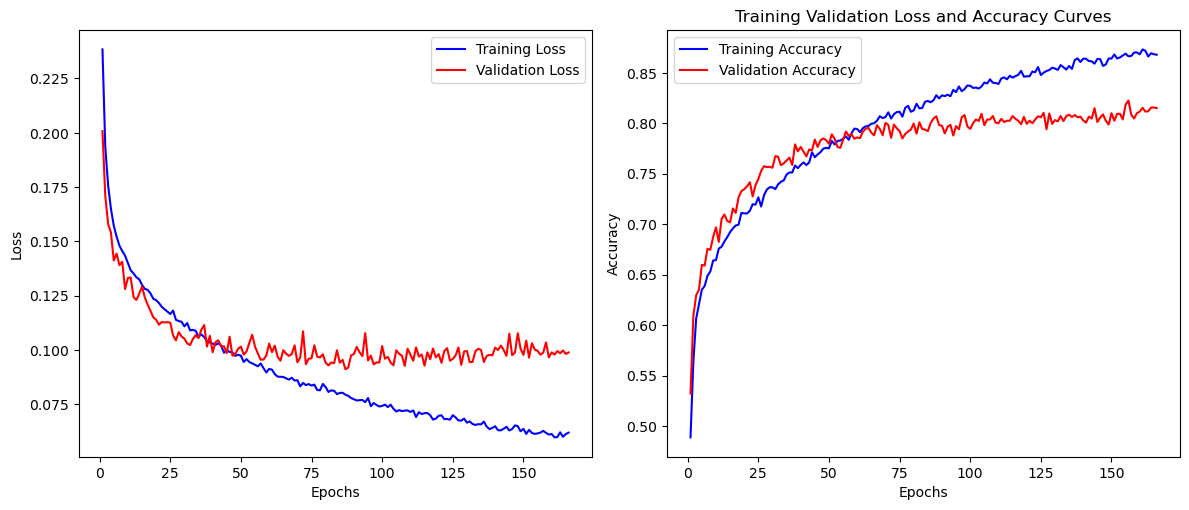

In [72]:
# Train Model
our_best_loss, our_best_accuracy, our_best_epoch = our_train_test.train(our_optimizer, 166, "our_model.pth")

Loss = 0.09858476483477427   Accuracy= 0.8058035714285714


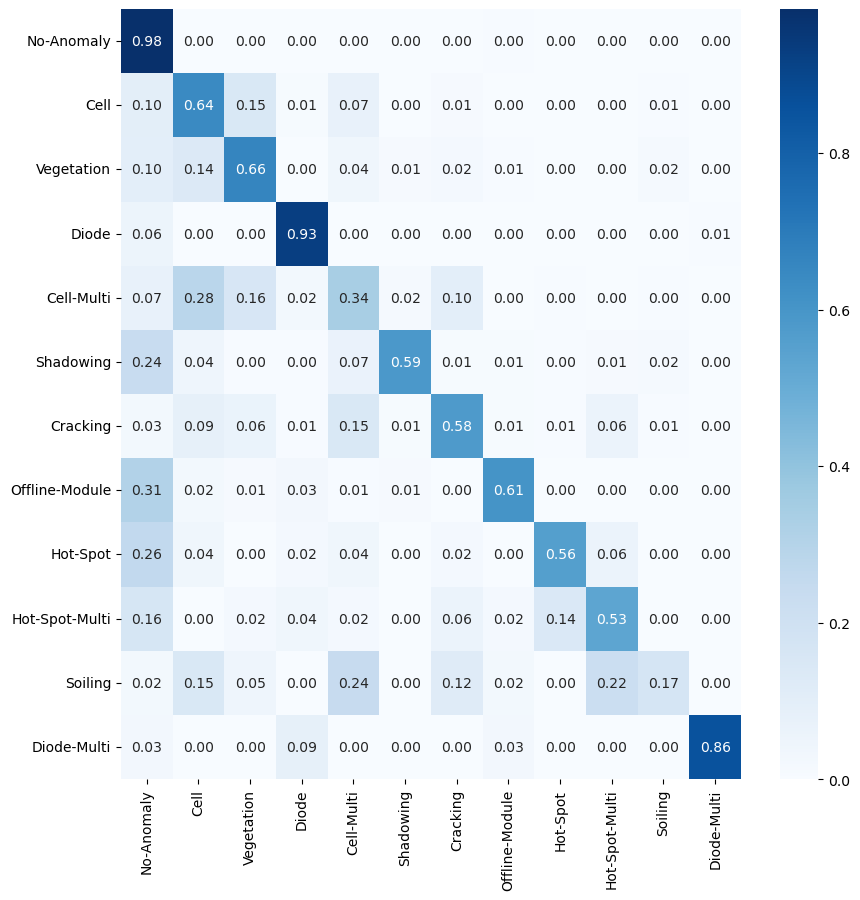

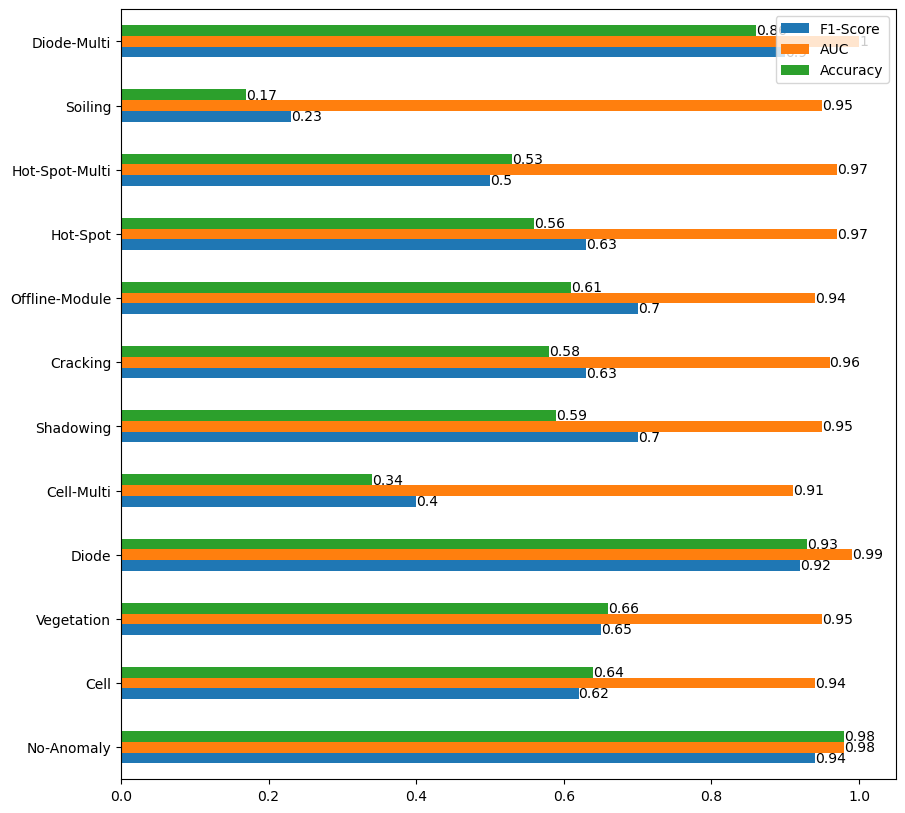

In [73]:
our_train_test.test()
our_train_test.plot_confusion_matrix()
our_train_test.plot_class_metrics()

---

# Adding Class Sensitive Learning (condition B)

In [157]:
total_imgs = len(solar_dataset.train_df)
class_weights = np.zeros(solar_dataset.num_classes)
for k, v in dict(solar_dataset.train_df.anomaly_class.value_counts()).items():
    class_weights[solar_dataset.classes_list.index(k)] = v
class_weights = torch.tensor([total_imgs/(class_imgs*solar_dataset.num_classes) for class_imgs in class_weights]).to(device)
print(class_weights)
print(solar_dataset.classes_list)

tensor([0.1667, 0.8875, 1.0169, 1.1124, 1.2946, 1.5780, 1.7720, 2.0127, 6.7091,
        6.7516, 8.2058, 9.5246], device='cuda:0', dtype=torch.float64)
['No-Anomaly', 'Cell', 'Vegetation', 'Diode', 'Cell-Multi', 'Shadowing', 'Cracking', 'Offline-Module', 'Hot-Spot', 'Hot-Spot-Multi', 'Soiling', 'Diode-Multi']


In [158]:
input_dim = (1, 40, 24)
output_dim = solar_dataset.num_classes
our_model_w = OurClassificator(input_dim, output_dim).to(device)
print(summary(our_model_w, (1, input_dim[0], input_dim[1], input_dim[2])))
our_loss_w = nn.BCELoss(weight=class_weights)
our_optimizer_w = Adam(our_model_w.parameters(), lr=0.0001)
our_train_test_w = utils.TrainTest(
    our_model_w,
    our_loss_w,
    32,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_basic,
)

Layer (type:depth-idx)                   Output Shape              Param #
OurClassificator                         [1, 12]                   --
├─Sequential: 1-1                        [1, 12]                   --
│    └─Conv2d: 2-1                       [1, 32, 20, 12]           544
│    └─BatchNorm2d: 2-2                  [1, 32, 20, 12]           64
│    └─LeakyReLU: 2-3                    [1, 32, 20, 12]           --
│    └─Dropout: 2-4                      [1, 32, 20, 12]           --
│    └─Conv2d: 2-5                       [1, 64, 10, 6]            32,832
│    └─BatchNorm2d: 2-6                  [1, 64, 10, 6]            128
│    └─LeakyReLU: 2-7                    [1, 64, 10, 6]            --
│    └─Dropout: 2-8                      [1, 64, 10, 6]            --
│    └─Conv2d: 2-9                       [1, 128, 5, 3]            131,200
│    └─BatchNorm2d: 2-10                 [1, 128, 5, 3]            256
│    └─LeakyReLU: 2-11                   [1, 128, 5, 3]            --
│  

Best Epoch # 0  Validation Loss= 0.33469754457473755  Validation Accu= 0.5001562988433885
Best Epoch # 1  Validation Loss= 0.32087674736976624  Validation Accu= 0.5029696780243826
Best Epoch # 2  Validation Loss= 0.30292806029319763  Validation Accu= 0.5404814004376368
Best Epoch # 3  Validation Loss= 0.29323044419288635  Validation Accu= 0.5798687089715536
Best Epoch # 4  Validation Loss= 0.27635952830314636  Validation Accu= 0.5933104095029696
Best Epoch # 5  Validation Loss= 0.26553693413734436  Validation Accu= 0.6183182244451391
Best Epoch # 7  Validation Loss= 0.2537681460380554  Validation Accu= 0.6189434198186934
Best Epoch # 8  Validation Loss= 0.24596723914146423  Validation Accu= 0.6333229134104408
Best Epoch # 10  Validation Loss= 0.24224188923835754  Validation Accu= 0.6355110972178806
Best Epoch # 11  Validation Loss= 0.23612244427204132  Validation Accu= 0.6402000625195373
Best Epoch # 12  Validation Loss= 0.23825983703136444  Validation Accu= 0.6511409815567365
Best Epo

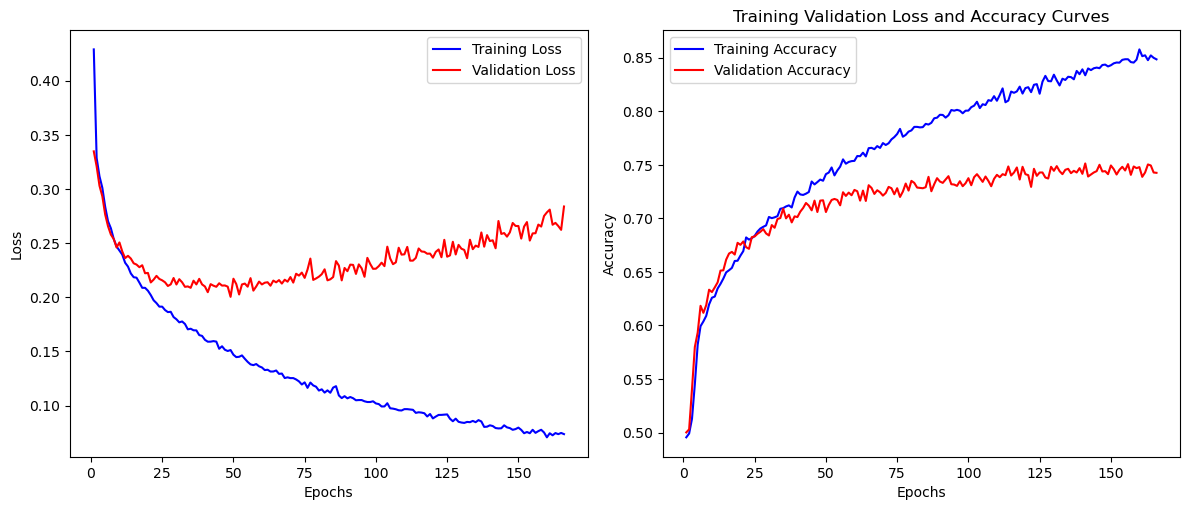

In [159]:
# Train Model
our_best_w_loss, our_best_w_accuracy, our_best_w_epoch = our_train_test_w.train(our_optimizer_w, 166, "our_model_w.pth")

Loss = 0.2245918909870088   Accuracy= 0.775


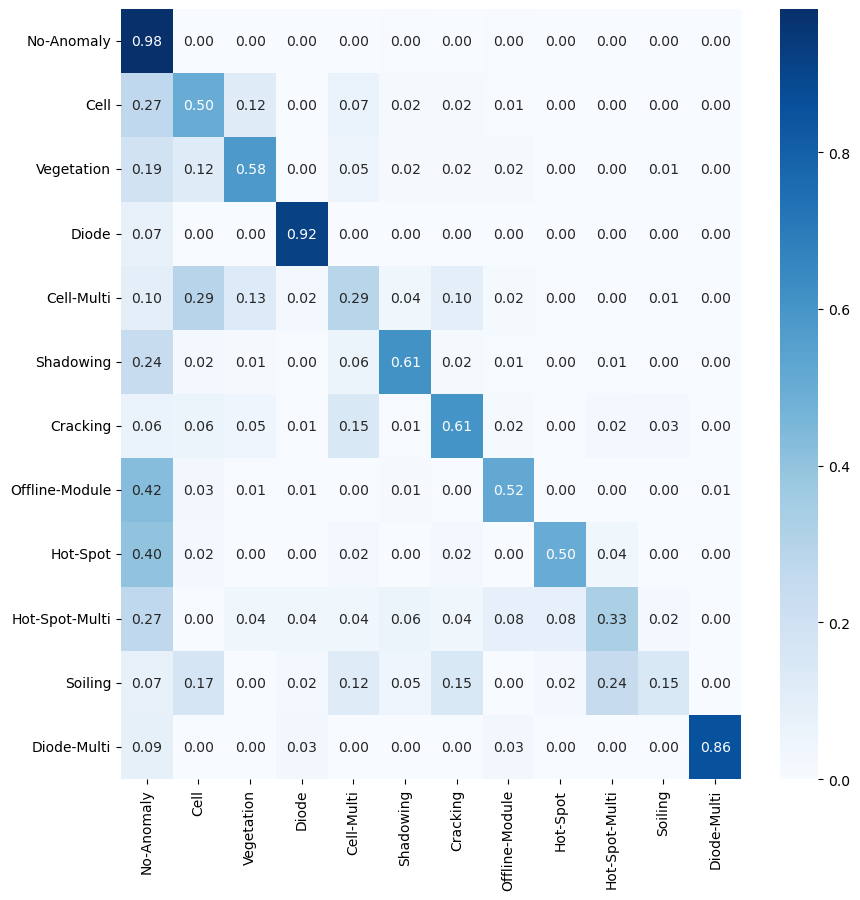

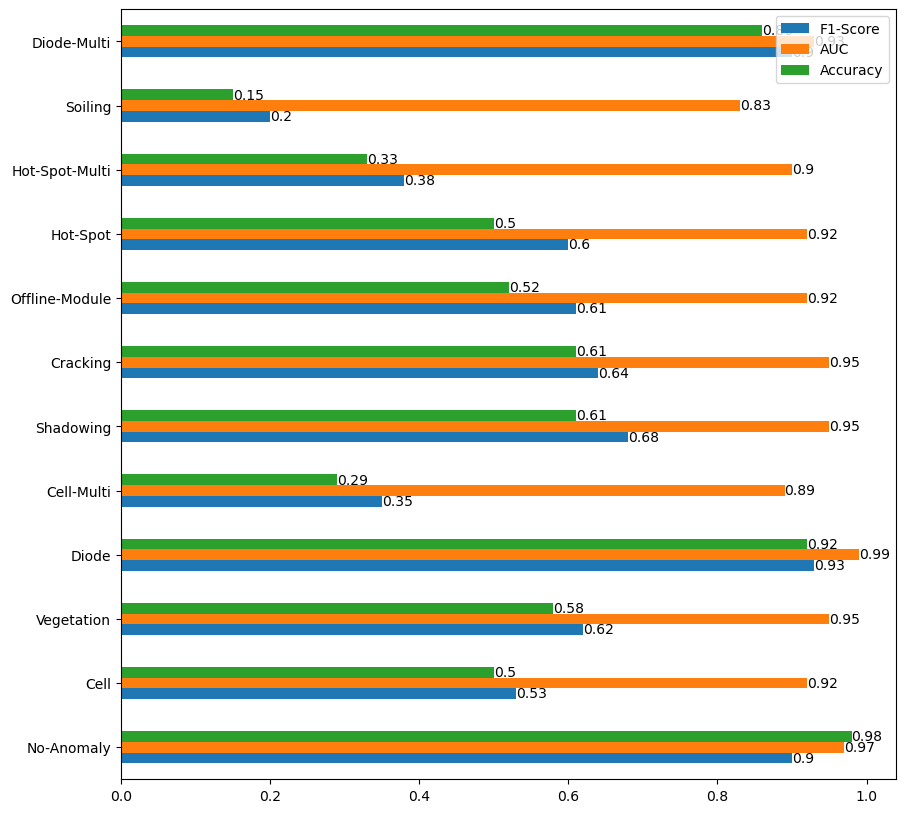

In [160]:
our_train_test_w.test()
our_train_test_w.plot_confusion_matrix()
our_train_test_w.plot_class_metrics()

---

# Adding Data Augmentation (condition C)

### Traditional data augmentation techniques

We first start with our baseline model, without using any data augmentation, however and since our dataset is relatively small, speacially if we consider that half of the dataset is only for one class (10000 samples for Non Anomaly Class), we decided to do some experiments with data augmentation.
Applying data augmentation usually provide better results since it increases the training set size by generating additional training samples by applying transformations such as rotation, flipping, scaling, and cropping to the original images. This increases the diversity of the dataset, which can be particularly beneficial when working with limited labeled data.

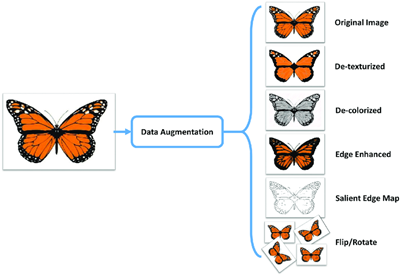

Below a few types of transformations were defined, some had more success than others (increasing or decreasing the model accuracy).
<br><br>
**RandomRotation**(degrees) : Rotate the image by angle.   
degrees : Range of degrees to select from. If degrees is a number instead of sequence like (min, max), the range of degrees will be (-degrees, +degrees).

**RandomHorizontalFlip**(p) : Horizontally flip the given PIL Image randomly with a given probability p

**RandomVertitalFlip**(p) : Vertitally flip the given PIL Image randomly with a given probability p

**ColorJitter**(brightness=0, contrast=0, saturation=0, hue=0) :
Randomly change the brightness, contrast and saturation of an image.
The parameters describe how much to jitter.



In [74]:
def preprocess_augment(image, aug_number=0, label=None):
    image_list = []

    # Define transformations for augmentation
    transforms_list = [
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.15),
            transforms.RandomVerticalFlip(p=0.15),
            #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            #transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.21),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5652, 0.5652, 0.5652), std=(0.5, 0.5, 0.5)),
            transforms.Grayscale(),
        ])
    ]

    # Define plain forward
    transforms_plain = [
        transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5652, 0.5652, 0.5652), std=(0.5, 0.5, 0.5)),
            transforms.Grayscale(),
        ])
    ]

    if aug_number == 0:
        image_list.append(transforms_plain[0](Image.fromarray(image)).numpy())
    else:
        for _ in range(aug_number):
            img_aug = transforms_list[0](Image.fromarray(image)).numpy()
            image_list.append(img_aug)

    return image_list

In [81]:
def preprocess_plain_augment(image, aug_number=0, label=None):
    image_list = []

    # Define transformations for augmentation
    transforms_list = [
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.15),
            transforms.RandomVerticalFlip(p=0.15),
            #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            #transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.21),
            transforms.ToTensor(),
        ])
    ]

    # Define plain forward
    transforms_plain = [
        transforms.Compose([
            transforms.ToTensor(),
        ])
    ]

    #image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if aug_number == 0:
        image_list.append(transforms_plain[0](Image.fromarray(image)).numpy())
    else:
        for _ in range(aug_number):
            img_aug = transforms_list[0](Image.fromarray(image)).numpy()
            image_list.append(img_aug)

    return image_list

In [82]:
# New model with Data Augmentation
input_dim = (1, 40, 24)
output_dim = solar_dataset.num_classes
our_model_imp_aug = OurClassificatorImp(input_dim, output_dim).to(device)
print(summary(our_model_imp_aug, (1, input_dim[0], input_dim[1], input_dim[2])))
our_loss_imp_aug = nn.BCEWithLogitsLoss()
our_optimizer_imp_aug = t_optim.Adahessian(
    our_model_imp_aug.parameters(),
    lr=0.15,
    betas=(0.9, 0.999),
    eps=1e-4,
    weight_decay=0.0,
    hessian_power=0.5,
)
our_train_test_imp_aug = utils.TrainTest(
    our_model_imp_aug,
    our_loss_imp_aug,
    64,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_plain_augment,
    augment=True,
)

Layer (type:depth-idx)                   Output Shape              Param #
OurClassificatorImp                      [1, 12]                   --
├─Sequential: 1-1                        [1, 12]                   --
│    └─Conv2d: 2-1                       [1, 20, 20, 12]           340
│    └─BatchNorm2d: 2-2                  [1, 20, 20, 12]           40
│    └─ReLU: 2-3                         [1, 20, 20, 12]           --
│    └─Dropout: 2-4                      [1, 20, 20, 12]           --
│    └─Conv2d: 2-5                       [1, 40, 10, 6]            12,840
│    └─BatchNorm2d: 2-6                  [1, 40, 10, 6]            80
│    └─ReLU: 2-7                         [1, 40, 10, 6]            --
│    └─Dropout: 2-8                      [1, 40, 10, 6]            --
│    └─Conv2d: 2-9                       [1, 80, 5, 3]             51,280
│    └─BatchNorm2d: 2-10                 [1, 80, 5, 3]             160
│    └─ReLU: 2-11                        [1, 80, 5, 3]             --
│    

In [83]:
# Train Model
our_best_imp_aug_loss, our_best_imp_aug_accuracy, our_best_imp_aug_epoch = our_train_test_imp_aug.train(our_optimizer_imp_aug, 166, "our_model_imp_aug.pth")

Best Epoch # 0  Validation Loss= 0.1921120434999466  Validation Accu= 0.48233823069709286
Best Epoch # 1  Validation Loss= 0.1698155403137207  Validation Accu= 0.5257893091591123
Best Epoch # 2  Validation Loss= 0.15972568094730377  Validation Accu= 0.583619881212879
Best Epoch # 3  Validation Loss= 0.1537453532218933  Validation Accu= 0.5998749609252891
Best Epoch # 6  Validation Loss= 0.14096812903881073  Validation Accu= 0.6477024070021882
Best Epoch # 9  Validation Loss= 0.12782450020313263  Validation Accu= 0.69740543919975
Best Epoch # 11  Validation Loss= 0.1261844038963318  Validation Accu= 0.708033760550172
Best Epoch # 13  Validation Loss= 0.12029758840799332  Validation Accu= 0.7205376680212566
Best Epoch # 18  Validation Loss= 0.12462744116783142  Validation Accu= 0.7221006564551422


Loss = 0.11993206109082888   Accuracy= 0.7802579365079365


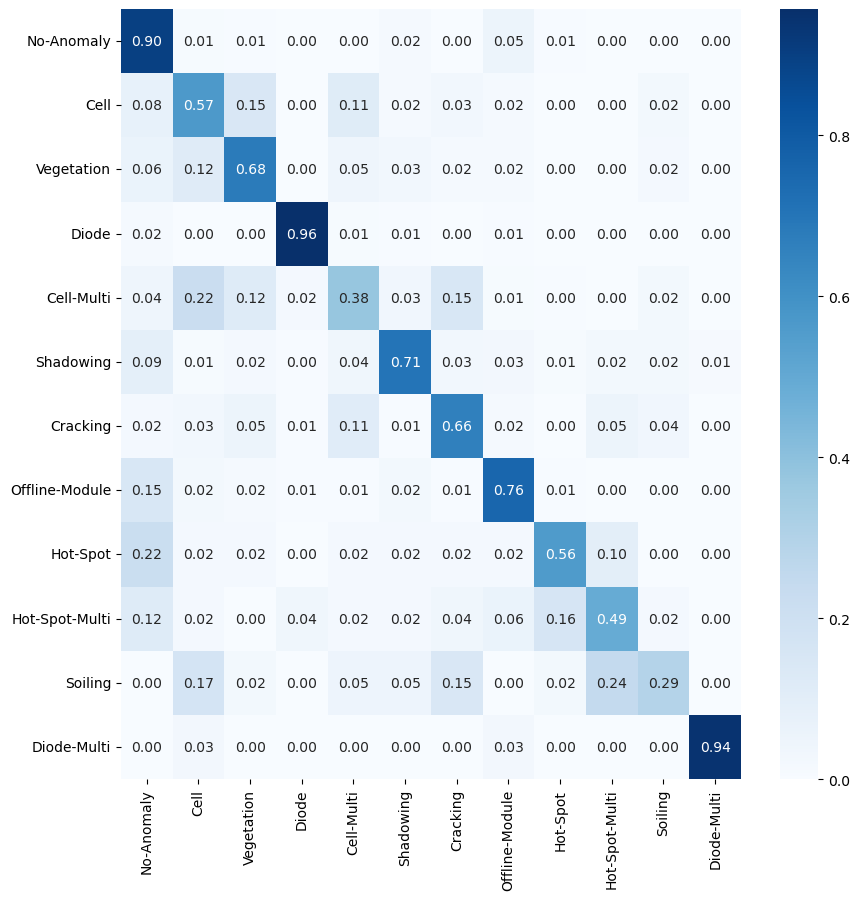

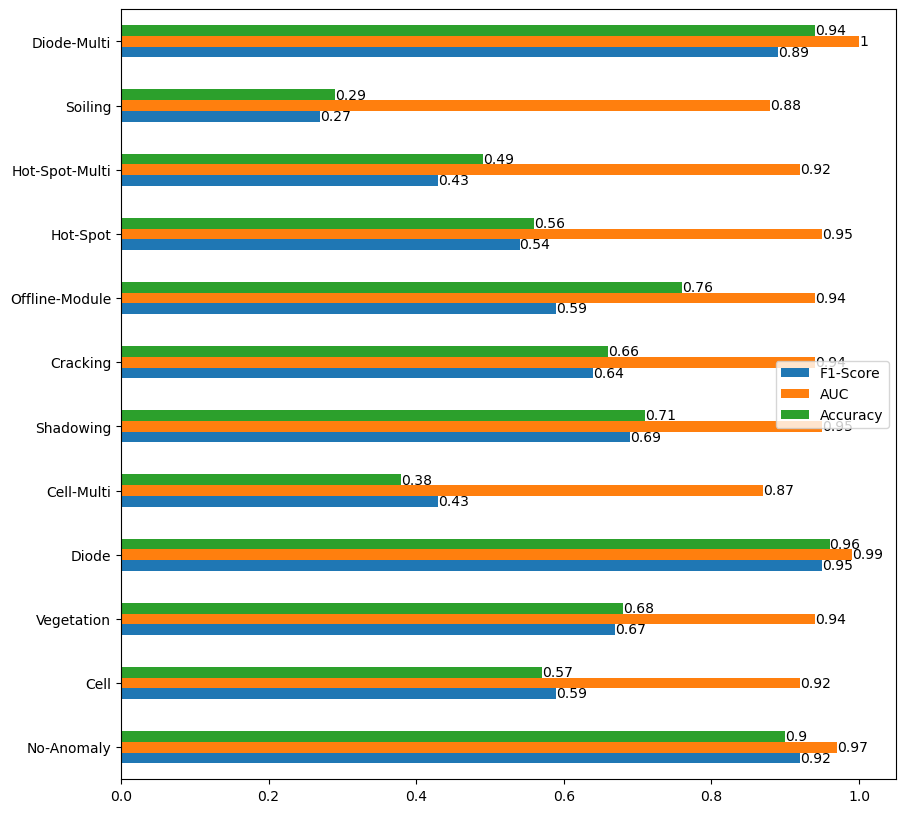

In [80]:
our_train_test_imp_aug.test()
our_train_test_imp_aug.plot_confusion_matrix()
our_train_test_imp_aug.plot_class_metrics()

---

# Data Augmentation (Condition D)

Using GAN's for Data Augmentation

TBD

In [11]:
def preprocess_gan(image, aug_number=0, label=None):
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = (image - 127.5) / 127.5
    image = image[np.newaxis]
    return [image]

In [12]:
class GAugmented(nn.Module):
    def __init__(self, img_shape, solar_dataset, latent_dim=100, features_gen=40, features_disc=40):
        super().__init__()
        self.img_size = img_shape[0] * img_shape[1] * img_shape[2]
        self.features_gen = features_gen
        self.features_disc = features_disc
        self.generator = self.Generator(latent_dim, img_shape, img_shape[0], features_gen, solar_dataset.num_classes).to(device)
        self.generator.weight_init(mean=0.0, std=0.02)
        self.discriminator = self.Discriminator(img_shape[0], features_disc, solar_dataset.num_classes).to(device)
        self.discriminator.weight_init(mean=0.0, std=0.02)
        self.lr_gen = 0.0002
        self.lr_disc = 0.0002
        self.batch_size = 128
        self.epochs = 500
        self.latent_dim = latent_dim
        self.img_shape = img_shape
        self.solar_dataset = solar_dataset

        print(summary(self.generator,
                [(1, latent_dim, 1, 1), (1, solar_dataset.num_classes, 1, 1)]))
        print(summary(self.discriminator,
                [(1, img_shape[0], img_shape[1], img_shape[2]),
                 (1, solar_dataset.num_classes, img_shape[1], img_shape[2])]))

        # Optimizers and loss function
        beta1 = 0.5
        self.optimizer_g = torch.optim.Adam(self.generator.parameters(), lr=self.lr_gen, betas=(beta1, 0.999))
        self.optimizer_d = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr_disc, betas=(beta1, 0.999))
        self.adversarial_loss = nn.BCELoss()
        self.conditioning_loss = nn.CrossEntropyLoss()

    def fit(self, dataloader):
        for epoch in range(self.epochs):
            for i, (real_imgs, real_labels) in enumerate(dataloader):
                real_imgs = real_imgs.to(device)
                real_labels = real_labels.to(device)
                batch_size = real_imgs.size(0)

                # Adversarial ground truths
                valid = torch.autograd.Variable(torch.ones(batch_size, 1)).to(device)
                #valid = torch.autograd.Variable(torch.full((batch_size, 1), 0.9)).to(device)
                fake = torch.autograd.Variable(torch.zeros(batch_size, 1)).to(device)

                # Generate fake data
                z = torch.autograd.Variable(torch.randn(batch_size, self.latent_dim, 1, 1)).to(device)
                fake_labels = torch.autograd.Variable(torch.FloatTensor(np.random.randint(0, self.solar_dataset.num_classes, batch_size))).to(device)

                # One hot encoded labels
                fill_d = torch.zeros([self.solar_dataset.num_classes, self.solar_dataset.num_classes, real_imgs.size(2), real_imgs.size(3)]).to(device)
                fill_g = torch.zeros([self.solar_dataset.num_classes, self.solar_dataset.num_classes, 1, 1]).to(device)
                for i in range(self.solar_dataset.num_classes):
                    fill_d[i, i, :, :] = 1
                    fill_g[i, i, :, :] = 1

                # Labels fake and real
                label_real_disc = fill_d[real_labels.to(torch.int64)]
                label_fake_disc = fill_d[fake_labels.to(torch.int64)]
                label_fake_gen = fill_g[fake_labels.to(torch.int64)]

                # Generate samples
                gen_imgs = self.generator(z, label_fake_gen)

                # Train discriminator
                self.optimizer_d.zero_grad()
                output_real = self.discriminator(real_imgs, label_real_disc)
                loss_real = self.adversarial_loss(output_real, valid)
                output_fake = self.discriminator(gen_imgs.detach(), label_fake_disc)
                loss_fake = self.adversarial_loss(output_fake, fake)
                #loss_cond_real = self.conditioning_loss(output_real, valid)
                #loss_cond_fake = self.conditioning_loss(output_fake, fake)
                #total_loss_disc = 0.50 * (loss_real + loss_fake)# + loss_cond_real + loss_cond_fake)
                total_loss_disc = 0.50 * (loss_real + loss_fake)
                total_loss_disc.backward()
                self.optimizer_d.step()

                # Train generator
                self.optimizer_g.zero_grad()
                output_fake_generator = self.discriminator(gen_imgs, label_fake_disc)
                loss_generator = self.adversarial_loss(output_fake_generator, valid)
                #loss_cond_generator = self.conditioning_loss(output_fake_generator, valid)
                total_loss_generator = loss_generator# + loss_cond_generator
                total_loss_generator.backward()
                self.optimizer_g.step()

            print(f"[Epoch {epoch}/{self.epochs}]"
                  f" [D loss: {total_loss_disc.item()}] [G loss: {total_loss_generator.item()}]")

            if epoch % 10 == 0:
                torch.save(self.state_dict(), "gan_model_temporary.pth")
                plt.figure(figsize=(15,15))
                for j in range(self.solar_dataset.num_classes):
                    image = self.augment(1, j)[0].cpu().numpy()
                    plt.subplot(6, 6, j+1)
                    plt.imshow((image.transpose(1, 2, 0) + 1.0) / 2.0)
                    plt.title(self.solar_dataset.classes_list[j])
                    plt.axis('off')
                plt.show()

    def augment(self, num, cat):
        def batch(iterable, n=1):
            l = len(iterable)
            for ndx in range(0, l, n):
                yield iterable[ndx:min(ndx + n, l)]

        with torch.no_grad():
            self.eval()
            gen_imgs = []
            for x_num in batch(range(num), n=100):
                n = len(x_num)
                z = torch.randn(n, self.latent_dim, 1, 1).to(device)
                c = torch.tensor(cat).repeat(n)
                #one_hot = nn.functional.one_hot(c.to(torch.int64), num_classes=num_classes)
                #l = one_hot.to(torch.float32)
                #l_g = l.view(n, num_classes, 1, 1).to(device)
                fill_g = torch.zeros([self.solar_dataset.num_classes, self.solar_dataset.num_classes, 1, 1]).to(device)
                for i in range(self.solar_dataset.num_classes):
                    fill_g[i, i, :, :] = 1
                l_g = fill_g[c.to(torch.int64)]
                gen = self.generator(z, l_g)
                for g in gen:
                    gen_imgs.append(g.view(self.img_shape[0], self.img_shape[1], self.img_shape[2]))
            return gen_imgs

    class Generator(nn.Module):
        def __init__(self, in_dim, out_shape, out_size, features, cats):
            super().__init__()
            self.in_dim = in_dim
            self.out_size = out_size
            self.out_shape = out_shape
            self.ngf = features
            self.cats = cats
            self.model_x = nn.Sequential(
                nn.ConvTranspose2d(self.in_dim, self.ngf*8, (5, 3), 1, 0),
                nn.BatchNorm2d(self.ngf*8),
                nn.LeakyReLU(0.2),
            )
            self.model_y = nn.Sequential(
                nn.ConvTranspose2d(self.cats, self.ngf*8, (5, 3), 1, 0),
                nn.BatchNorm2d(self.ngf*8),
                nn.LeakyReLU(0.2),
            )
            self.model_f = nn.Sequential(
                # Input is Zx5x3
                nn.ConvTranspose2d(self.ngf*16, self.ngf*8, 4, 2, 1),
                nn.BatchNorm2d(self.ngf*8),
                nn.LeakyReLU(0.2),
                # Input is Zx10x6
                nn.ConvTranspose2d(self.ngf*8, self.ngf*4, 4, 2, 1),
                nn.BatchNorm2d(self.ngf*4),
                nn.LeakyReLU(0.2),
                # Input is Zx20x12
                nn.ConvTranspose2d(self.ngf*4, self.ngf*2, 4, 2, 1),
                nn.BatchNorm2d(self.ngf*2),
                nn.LeakyReLU(0.2),
                # Input is Zx40x24
                nn.ConvTranspose2d(self.ngf*2, self.out_size, 3, 1, 1),
                #nn.Dropout(0.50),
                nn.Tanh(),
                # Output is Cx40x24
            )

        def weight_init(self, mean, std):
            for m in self._modules:
                self.normal_init(self._modules[m], mean, std)

        def normal_init(self, m, mean, std):
            if isinstance(m, nn.Sequential):
                for l in m:
                    if isinstance(l, nn.ConvTranspose2d) or isinstance(l, nn.Conv2d):
                        l.weight.data.normal_(mean, std)
                        l.bias.data.zero_()
                        print(l)

        def forward(self, z, cat):
            #x = self.model_x(self.lx(z.view(z.size(0), -1)).view(-1, self.ngf**2, 1, 1))
            #y = self.model_y(self.ly(cat.view(cat.size(0), -1)).view(-1, self.ngf**2, 1, 1))
            x = self.model_x(z)
            y = self.model_y(cat)
            img = self.model_f(torch.cat([x, y], 1))
            return img.view(-1, self.out_shape[0], self.out_shape[1], self.out_shape[2])

    class Discriminator(nn.Module):
        def __init__(self, in_dim, features, cats):
            super().__init__()
            self.in_dim = in_dim
            self.ndf = features
            self.cats = cats
            self.model_x = nn.Sequential(
                nn.Conv2d(self.in_dim, self.ndf, 4, 2, 1),
                nn.BatchNorm2d(self.ndf),
                nn.ReLU(),
            )
            self.model_y = nn.Sequential(
                nn.Conv2d(self.cats, self.ndf, 4, 2, 1),
                nn.BatchNorm2d(self.ndf),
                nn.ReLU(),
            )
            self.model_f = nn.Sequential(
                # Input is Cx40x24
                nn.Conv2d(self.ndf*2, self.ndf*4, 4, 2, 1),
                nn.BatchNorm2d(self.ndf*4),
                nn.ReLU(),
                # Input is Zx20x12
                nn.Conv2d(self.ndf*4, self.ndf*8, 4, 2, 1),
                nn.BatchNorm2d(self.ndf*8),
                nn.ReLU(),
                # Input is Zx10x6
                nn.Conv2d(self.ndf*8, self.ndf*16, 3, 1, 1),
                nn.BatchNorm2d(self.ndf*16),
                nn.ReLU(),
                # Input is Zx5x3
                ##nn.Conv2d(self.ndf*16, 1, (5, 3), 1, 0),
                nn.Flatten(),
                nn.Linear(self.ndf*16*5*3, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 1),
                #nn.Dropout(0.50),
                nn.Sigmoid(),
            )

        def weight_init(self, mean, std):
            for m in self._modules:
                self.normal_init(self._modules[m], mean, std)

        def normal_init(self, m, mean, std):
            if isinstance(m, nn.Sequential):
                for l in m:
                    if isinstance(l, nn.ConvTranspose2d) or isinstance(l, nn.Conv2d):
                        l.weight.data.normal_(mean, std)
                        l.bias.data.zero_()
                        print(l)

        def forward(self, x, cat):
            x = self.model_x(x)
            y = self.model_y(cat)
            out = self.model_f(torch.cat([x, y], 1))
            return out.view(out.size(0), -1)

In [13]:
input_dim = (1, 40, 24)
g_model = GAugmented(input_dim, solar_dataset).to(device)
g_train_test = utils.TrainTest(
    g_model,
    None,
    g_model.batch_size,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_gan,
)

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 1, 40, 24]            --
├─Sequential: 1-1                        [1, 160, 5, 3]            --
│    └─ConvTranspose2d: 2-1              [1, 160, 5, 3]            240,160
│    └─BatchNorm2d: 2-2                  [1, 160, 5, 3]            320
│    └─LeakyReLU: 2-3                    [1, 160, 5, 3]            --
├─Sequential: 1-2                        [1, 160, 5, 3]            --
│    └─ConvTranspose2d: 2-4              [1, 160, 5, 3]            28,960
│    └─BatchNorm2d: 2-5                  [1, 160, 5, 3]            320
│    └─LeakyReLU: 2-6                    [1, 160, 5, 3]            --
├─Sequential: 1-3                        [1, 1, 40, 24]            --
│    └─ConvTranspose2d: 2-7              [1, 160, 10, 6]           819,360
│    └─BatchNorm2d: 2-8                  [1, 160, 10, 6]           320
│    └─LeakyReLU: 2-9                    [1, 160, 10, 6]           -

[Epoch 0/500] [D loss: 0.9454298615455627] [G loss: 3.0606839656829834]


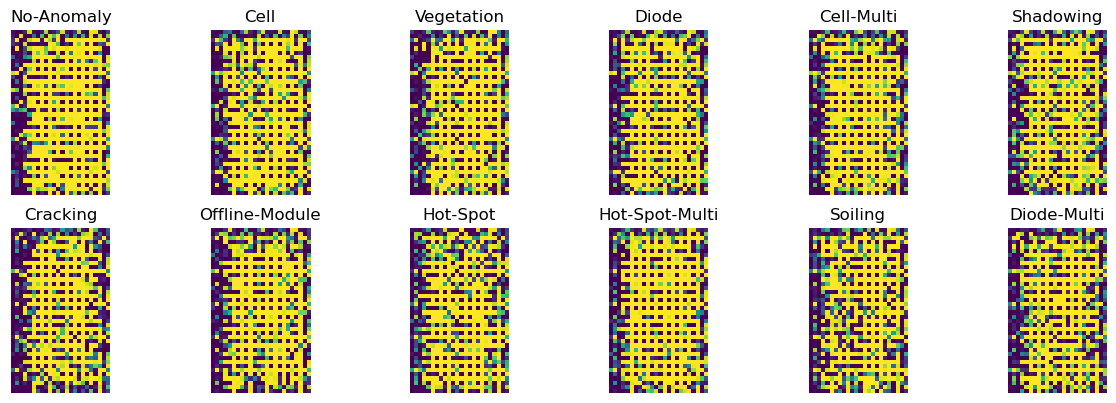

[Epoch 1/500] [D loss: 0.042429108172655106] [G loss: 7.926672458648682]
[Epoch 2/500] [D loss: 0.662506639957428] [G loss: 2.279519557952881]
[Epoch 3/500] [D loss: 0.2885633707046509] [G loss: 2.477151393890381]
[Epoch 4/500] [D loss: 0.7638333439826965] [G loss: 1.4036601781845093]
[Epoch 5/500] [D loss: 0.6584385633468628] [G loss: 2.5980958938598633]
[Epoch 6/500] [D loss: 0.5131738781929016] [G loss: 2.0801403522491455]
[Epoch 7/500] [D loss: 0.5024199485778809] [G loss: 3.4928202629089355]
[Epoch 8/500] [D loss: 0.46943384408950806] [G loss: 2.4008052349090576]
[Epoch 9/500] [D loss: 0.45118439197540283] [G loss: 1.9074355363845825]
[Epoch 10/500] [D loss: 0.6575192809104919] [G loss: 1.520561695098877]


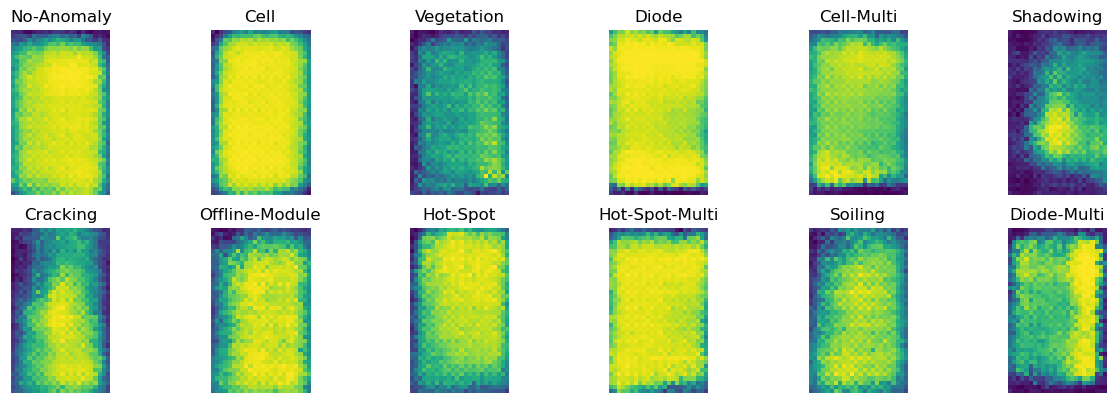

[Epoch 11/500] [D loss: 0.2553439140319824] [G loss: 1.965644121170044]
[Epoch 12/500] [D loss: 0.14583399891853333] [G loss: 3.551419496536255]
[Epoch 13/500] [D loss: 0.5986108779907227] [G loss: 3.839512348175049]
[Epoch 14/500] [D loss: 0.285793662071228] [G loss: 2.0164313316345215]
[Epoch 15/500] [D loss: 0.10419481992721558] [G loss: 3.8673183917999268]
[Epoch 16/500] [D loss: 0.21612973511219025] [G loss: 2.439373016357422]
[Epoch 17/500] [D loss: 1.3830875158309937] [G loss: 0.9275542497634888]
[Epoch 18/500] [D loss: 0.37137025594711304] [G loss: 1.9933444261550903]
[Epoch 19/500] [D loss: 0.39632198214530945] [G loss: 2.579871892929077]
[Epoch 20/500] [D loss: 5.740956839872524e-05] [G loss: 9.174352645874023]


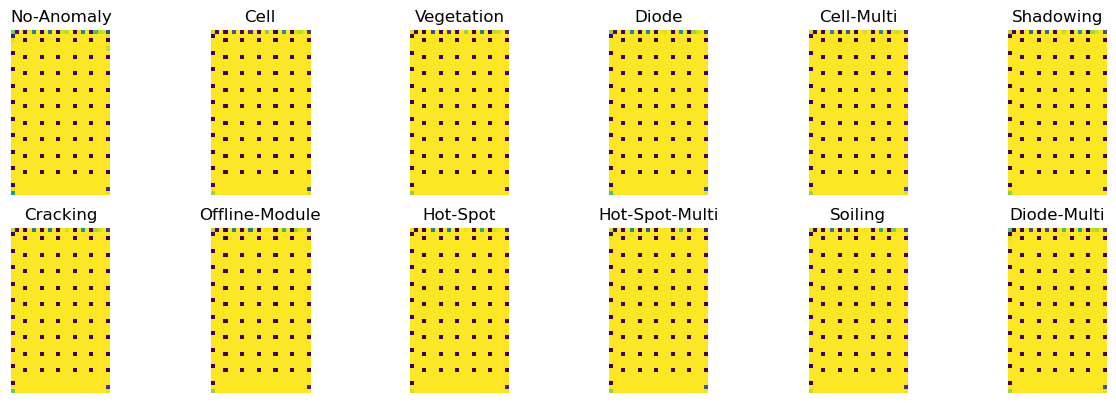

[Epoch 21/500] [D loss: 6.414267409127206e-05] [G loss: 9.010604858398438]
[Epoch 22/500] [D loss: 0.6542500257492065] [G loss: 1.699029564857483]
[Epoch 23/500] [D loss: 0.12527304887771606] [G loss: 2.232490301132202]
[Epoch 24/500] [D loss: 0.41808992624282837] [G loss: 2.6878457069396973]
[Epoch 25/500] [D loss: 0.5888415575027466] [G loss: 1.1448174715042114]
[Epoch 26/500] [D loss: 0.2469697743654251] [G loss: 3.049983501434326]
[Epoch 27/500] [D loss: 1.2729687690734863] [G loss: 4.187757968902588]
[Epoch 28/500] [D loss: 1.012765645980835] [G loss: 2.251117467880249]
[Epoch 29/500] [D loss: 0.10503920912742615] [G loss: 4.177415370941162]
[Epoch 30/500] [D loss: 0.36540350317955017] [G loss: 3.5427329540252686]


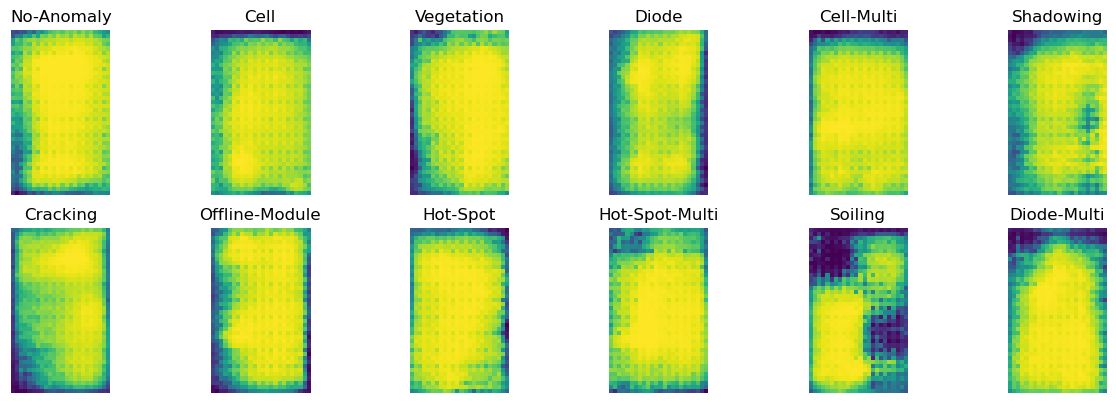

[Epoch 31/500] [D loss: 0.22137904167175293] [G loss: 3.7352070808410645]
[Epoch 32/500] [D loss: 0.2618662714958191] [G loss: 7.747946262359619]
[Epoch 33/500] [D loss: 0.38049182295799255] [G loss: 3.5860137939453125]
[Epoch 34/500] [D loss: 0.3562801480293274] [G loss: 7.47613000869751]
[Epoch 35/500] [D loss: 0.12519919872283936] [G loss: 3.884978771209717]
[Epoch 36/500] [D loss: 1.637682318687439] [G loss: 5.109218597412109]
[Epoch 37/500] [D loss: 0.5546954274177551] [G loss: 5.260368824005127]
[Epoch 38/500] [D loss: 0.3080555200576782] [G loss: 5.626467227935791]
[Epoch 39/500] [D loss: 0.04080205410718918] [G loss: 4.778548717498779]
[Epoch 40/500] [D loss: 0.041590917855501175] [G loss: 4.623520851135254]


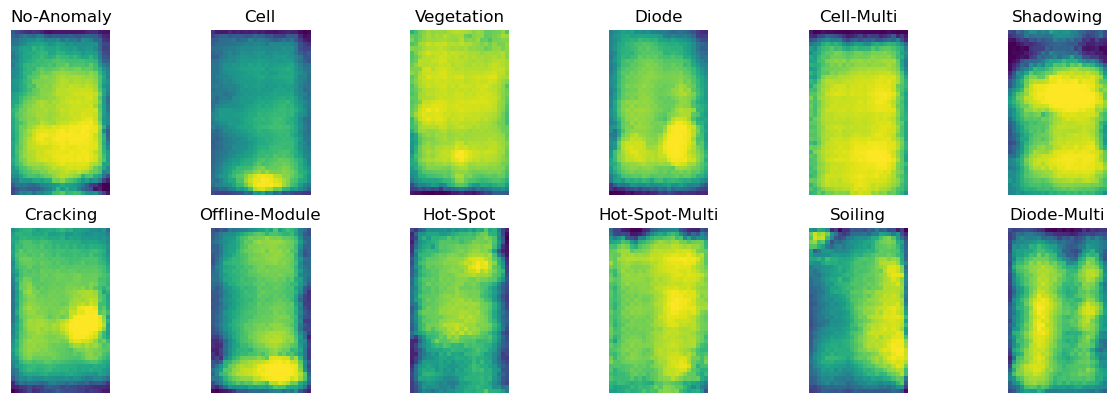

[Epoch 41/500] [D loss: 0.16226646304130554] [G loss: 4.634283542633057]
[Epoch 42/500] [D loss: 0.09097814559936523] [G loss: 5.099030494689941]
[Epoch 43/500] [D loss: 0.04900110885500908] [G loss: 5.5807881355285645]
[Epoch 44/500] [D loss: 0.08977162092924118] [G loss: 7.834105491638184]
[Epoch 45/500] [D loss: 0.20789757370948792] [G loss: 3.8903441429138184]
[Epoch 46/500] [D loss: 0.040715157985687256] [G loss: 4.801232814788818]
[Epoch 47/500] [D loss: 0.18053314089775085] [G loss: 5.333161354064941]
[Epoch 48/500] [D loss: 0.16419576108455658] [G loss: 14.831767082214355]
[Epoch 49/500] [D loss: 0.2432832270860672] [G loss: 9.669692993164062]
[Epoch 50/500] [D loss: 0.15117697417736053] [G loss: 11.769583702087402]


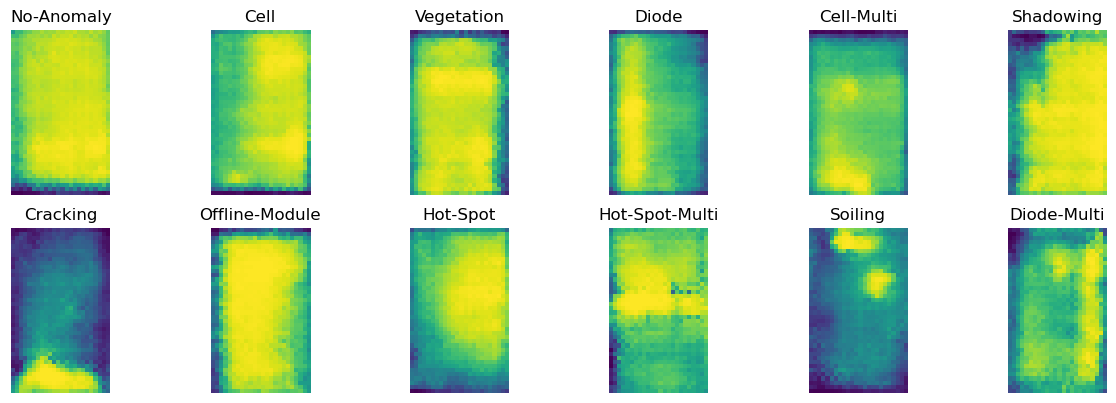

[Epoch 51/500] [D loss: 0.0018854255322366953] [G loss: 7.6058244705200195]
[Epoch 52/500] [D loss: 0.0848480612039566] [G loss: 12.900879859924316]
[Epoch 53/500] [D loss: 0.01905069872736931] [G loss: 9.591194152832031]
[Epoch 54/500] [D loss: 0.0013252785429358482] [G loss: 7.474053859710693]
[Epoch 55/500] [D loss: 0.0017663666512817144] [G loss: 7.358500003814697]
[Epoch 56/500] [D loss: 0.015501686371862888] [G loss: 11.248754501342773]
[Epoch 57/500] [D loss: 0.06572970002889633] [G loss: 8.443216323852539]
[Epoch 58/500] [D loss: 0.053248073905706406] [G loss: 11.31171989440918]
[Epoch 59/500] [D loss: 0.007504090666770935] [G loss: 7.508072376251221]
[Epoch 60/500] [D loss: 0.46151137351989746] [G loss: 14.295523643493652]


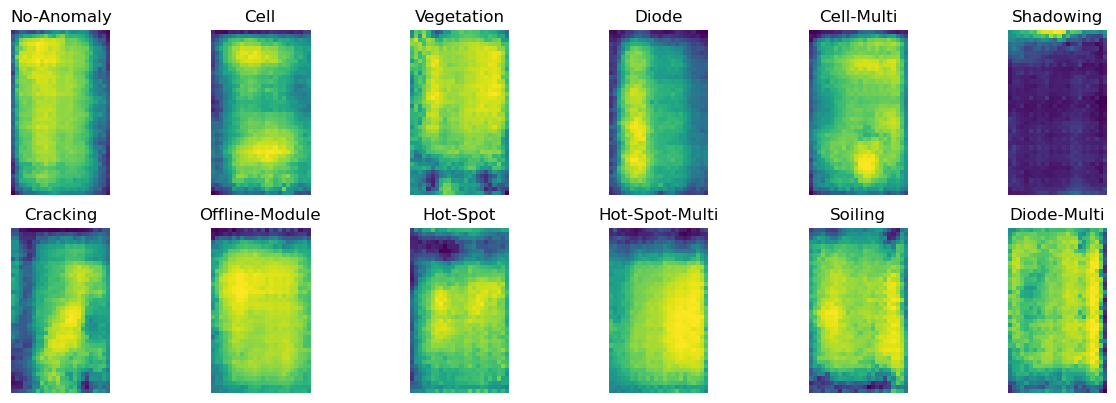

[Epoch 61/500] [D loss: 0.015691356733441353] [G loss: 6.4990153312683105]
[Epoch 62/500] [D loss: 0.050554025918245316] [G loss: 7.819823741912842]
[Epoch 63/500] [D loss: 0.004765209276229143] [G loss: 11.414749145507812]
[Epoch 64/500] [D loss: 0.08964473009109497] [G loss: 7.057199001312256]
[Epoch 65/500] [D loss: 0.01526317372918129] [G loss: 9.569918632507324]
[Epoch 66/500] [D loss: 0.06023893132805824] [G loss: 18.184471130371094]
[Epoch 67/500] [D loss: 0.0023949802853167057] [G loss: 7.647907257080078]
[Epoch 68/500] [D loss: 0.06553792953491211] [G loss: 11.459222793579102]
[Epoch 69/500] [D loss: 0.005873680114746094] [G loss: 8.619624137878418]
[Epoch 70/500] [D loss: 0.03860917314887047] [G loss: 5.768165588378906]


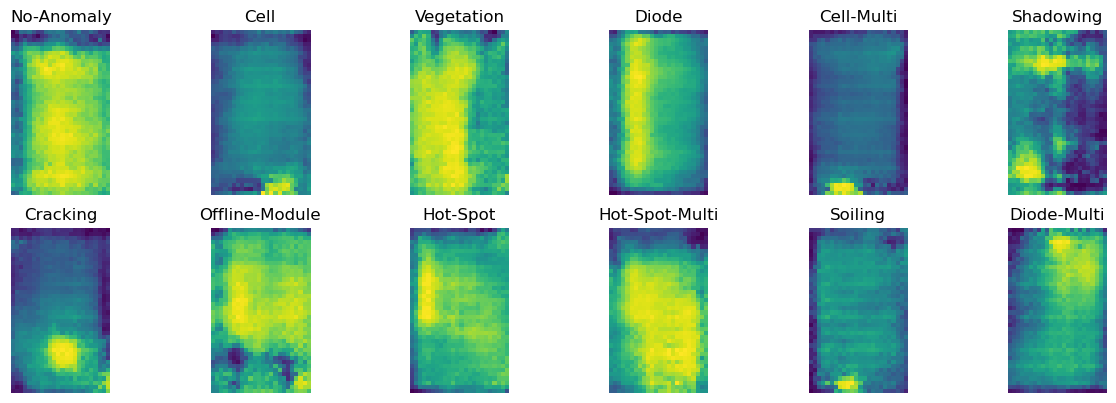

[Epoch 71/500] [D loss: 0.005829948466271162] [G loss: 5.73046350479126]
[Epoch 72/500] [D loss: 0.007065457757562399] [G loss: 7.2334818840026855]
[Epoch 73/500] [D loss: 0.46558964252471924] [G loss: 5.575570106506348]
[Epoch 74/500] [D loss: 0.08200779557228088] [G loss: 9.048627853393555]
[Epoch 75/500] [D loss: 0.03553491085767746] [G loss: 9.260062217712402]
[Epoch 76/500] [D loss: 0.0008681311155669391] [G loss: 6.693112850189209]
[Epoch 77/500] [D loss: 0.015462039038538933] [G loss: 9.978103637695312]
[Epoch 78/500] [D loss: 0.0008544642478227615] [G loss: 7.772738456726074]
[Epoch 79/500] [D loss: 0.0034664603881537914] [G loss: 6.920841693878174]
[Epoch 80/500] [D loss: 0.0016317456029355526] [G loss: 6.760530948638916]


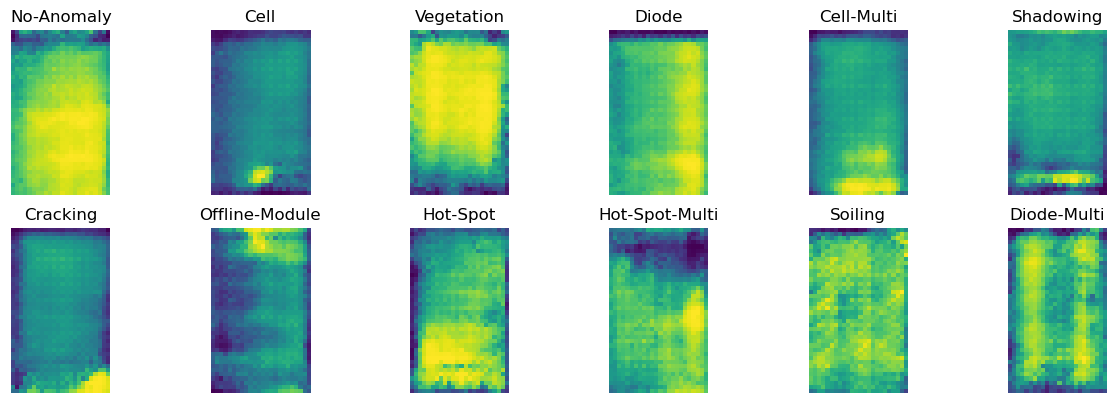

[Epoch 81/500] [D loss: 0.01777859590947628] [G loss: 9.595645904541016]
[Epoch 82/500] [D loss: 0.059650201350450516] [G loss: 8.935052871704102]
[Epoch 83/500] [D loss: 0.027617819607257843] [G loss: 7.1654953956604]
[Epoch 84/500] [D loss: 0.0036118209827691317] [G loss: 7.381398677825928]
[Epoch 85/500] [D loss: 0.4549388885498047] [G loss: 0.05374669283628464]
[Epoch 86/500] [D loss: 0.001176177989691496] [G loss: 10.10216236114502]
[Epoch 87/500] [D loss: 0.02458760142326355] [G loss: 11.611350059509277]
[Epoch 88/500] [D loss: 0.002075678203254938] [G loss: 6.2931294441223145]
[Epoch 89/500] [D loss: 0.02823697030544281] [G loss: 6.246102333068848]
[Epoch 90/500] [D loss: 0.00521110650151968] [G loss: 7.135922431945801]


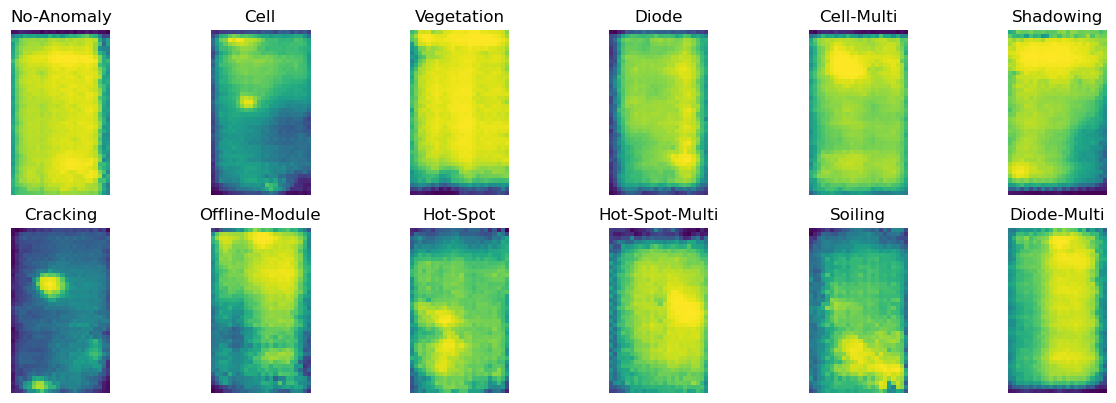

[Epoch 91/500] [D loss: 0.004163234960287809] [G loss: 7.278491973876953]
[Epoch 92/500] [D loss: 1.773778535607562e-06] [G loss: 14.325190544128418]
[Epoch 93/500] [D loss: 0.0272373054176569] [G loss: 6.133760929107666]
[Epoch 94/500] [D loss: 0.005554648581892252] [G loss: 5.393299102783203]
[Epoch 95/500] [D loss: 0.01054384745657444] [G loss: 9.810111999511719]
[Epoch 96/500] [D loss: 0.02699173055589199] [G loss: 7.463207244873047]
[Epoch 97/500] [D loss: 0.043634407222270966] [G loss: 10.92712116241455]
[Epoch 98/500] [D loss: 0.32650694251060486] [G loss: 8.939064979553223]
[Epoch 99/500] [D loss: 0.006044193636626005] [G loss: 5.964483737945557]
[Epoch 100/500] [D loss: 0.004742663353681564] [G loss: 6.642333507537842]


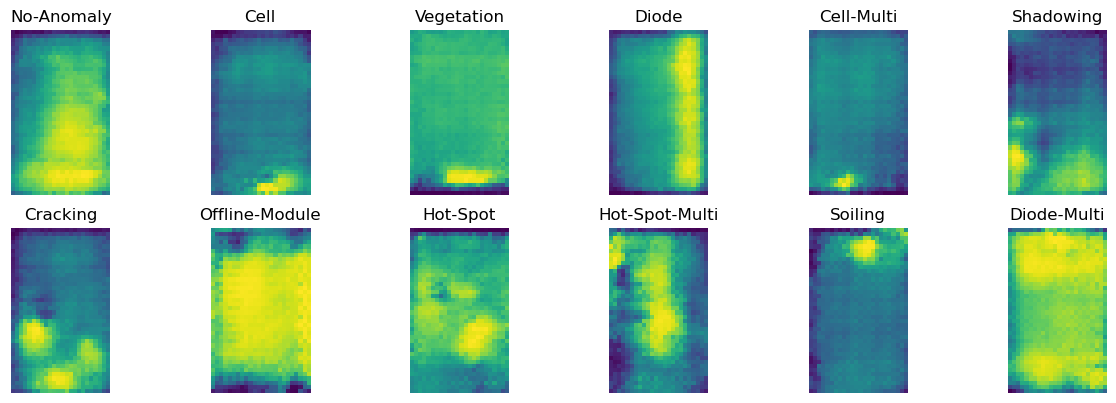

[Epoch 101/500] [D loss: 0.0003560681361705065] [G loss: 7.132142543792725]
[Epoch 102/500] [D loss: 0.19958613812923431] [G loss: 12.623348236083984]
[Epoch 103/500] [D loss: 0.011299683712422848] [G loss: 6.3095011711120605]
[Epoch 104/500] [D loss: 6.869891512906179e-05] [G loss: 8.947530746459961]
[Epoch 105/500] [D loss: 0.012623713351786137] [G loss: 8.862723350524902]
[Epoch 106/500] [D loss: 0.021044863387942314] [G loss: 7.512296199798584]
[Epoch 107/500] [D loss: 0.002701195189729333] [G loss: 5.845029830932617]
[Epoch 108/500] [D loss: 0.0008076846715994179] [G loss: 7.387507438659668]
[Epoch 109/500] [D loss: 0.05753353610634804] [G loss: 11.677145004272461]
[Epoch 110/500] [D loss: 0.0021427941974252462] [G loss: 6.612046241760254]


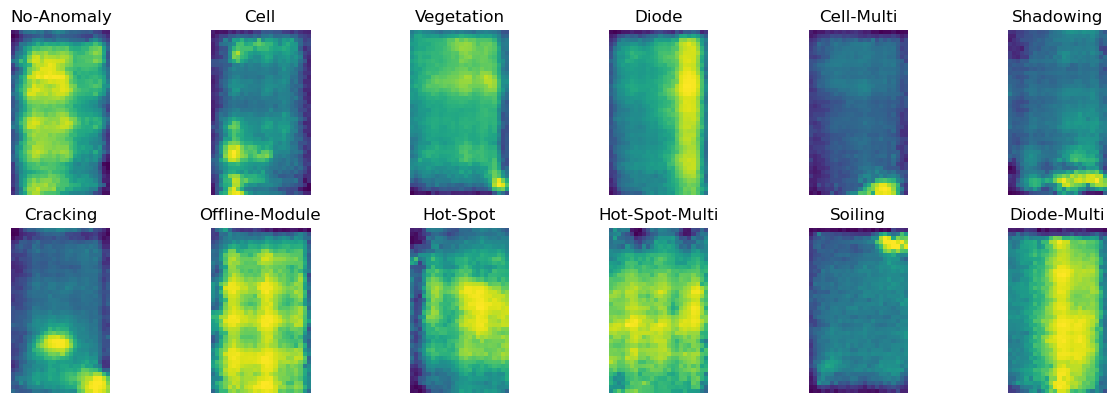

[Epoch 111/500] [D loss: 0.014168540947139263] [G loss: 8.055729866027832]
[Epoch 112/500] [D loss: 0.0005654009291902184] [G loss: 7.0752949714660645]
[Epoch 113/500] [D loss: 0.16416850686073303] [G loss: 9.465006828308105]
[Epoch 114/500] [D loss: 0.016325131058692932] [G loss: 6.081523895263672]
[Epoch 115/500] [D loss: 1.3640282154083252] [G loss: 3.722820281982422]
[Epoch 116/500] [D loss: 0.04701993614435196] [G loss: 11.34136962890625]
[Epoch 117/500] [D loss: 0.009161530062556267] [G loss: 6.72149658203125]
[Epoch 118/500] [D loss: 0.002844788832589984] [G loss: 5.902135848999023]
[Epoch 119/500] [D loss: 0.010489488020539284] [G loss: 5.153433799743652]
[Epoch 120/500] [D loss: 0.09911143034696579] [G loss: 9.091909408569336]


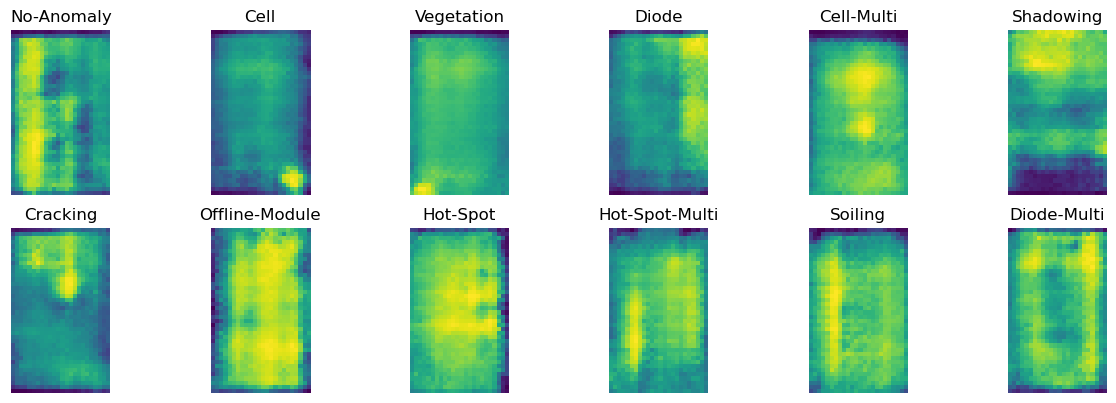

[Epoch 121/500] [D loss: 0.0397292785346508] [G loss: 7.1331682205200195]
[Epoch 122/500] [D loss: 0.015082849189639091] [G loss: 6.434393882751465]
[Epoch 123/500] [D loss: 0.041578855365514755] [G loss: 6.1162285804748535]
[Epoch 124/500] [D loss: 0.002500704023987055] [G loss: 6.531599044799805]
[Epoch 125/500] [D loss: 0.006010276731103659] [G loss: 5.611630439758301]
[Epoch 126/500] [D loss: 1.6700267224223353e-05] [G loss: 11.225412368774414]
[Epoch 127/500] [D loss: 0.0007171555771492422] [G loss: 7.475965976715088]
[Epoch 128/500] [D loss: 0.03788992762565613] [G loss: 12.20225715637207]
[Epoch 129/500] [D loss: 0.004213658627122641] [G loss: 6.135993003845215]
[Epoch 130/500] [D loss: 0.005945832468569279] [G loss: 5.333662033081055]


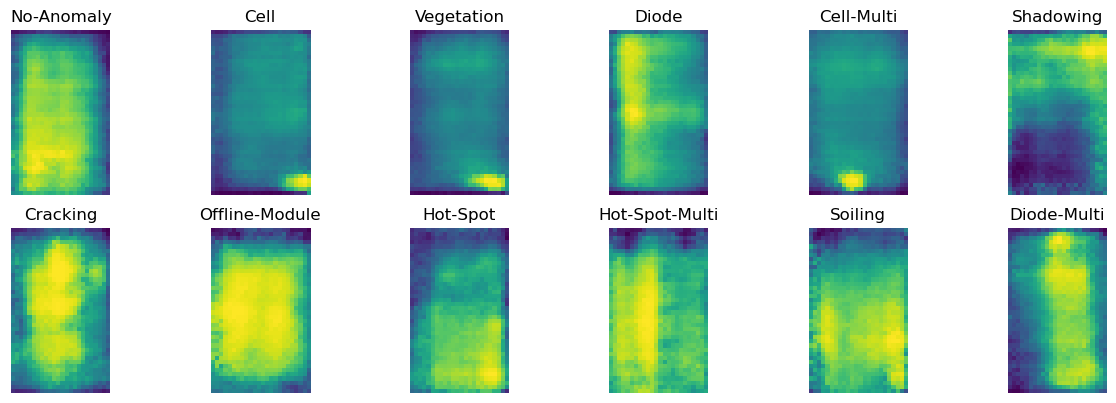

[Epoch 131/500] [D loss: 0.330924391746521] [G loss: 11.743698120117188]
[Epoch 132/500] [D loss: 0.0035573181230574846] [G loss: 5.792785167694092]
[Epoch 133/500] [D loss: 0.014499201439321041] [G loss: 10.00479507446289]
[Epoch 134/500] [D loss: 0.1260022670030594] [G loss: 8.969059944152832]
[Epoch 135/500] [D loss: 0.012427696958184242] [G loss: 8.089689254760742]
[Epoch 136/500] [D loss: 0.012235861271619797] [G loss: 9.778219223022461]
[Epoch 137/500] [D loss: 0.059917908161878586] [G loss: 9.490931510925293]
[Epoch 138/500] [D loss: 0.00044007430551573634] [G loss: 7.830257892608643]
[Epoch 139/500] [D loss: 0.005132773891091347] [G loss: 5.216513156890869]
[Epoch 140/500] [D loss: 0.29270559549331665] [G loss: 9.927456855773926]


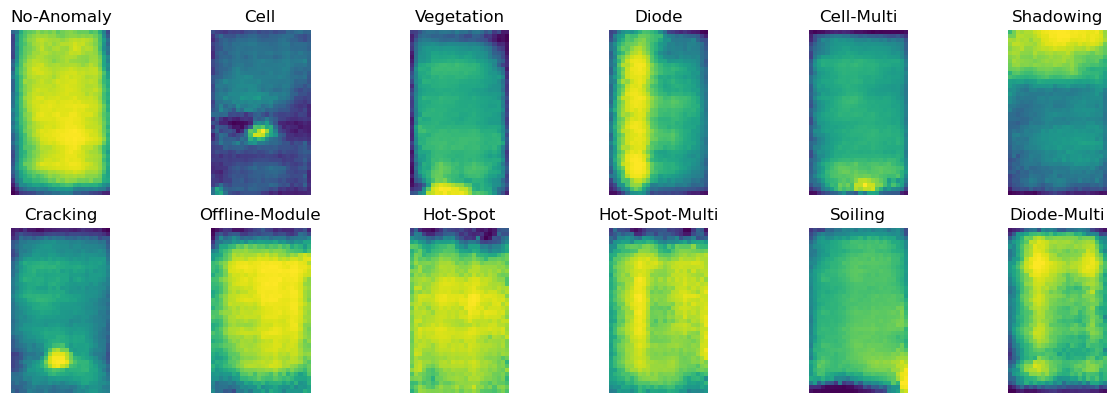

[Epoch 141/500] [D loss: 0.0020113401114940643] [G loss: 6.50860595703125]
[Epoch 142/500] [D loss: 0.002085520653054118] [G loss: 6.490177154541016]
[Epoch 143/500] [D loss: 0.005199849605560303] [G loss: 5.748632907867432]
[Epoch 144/500] [D loss: 0.06862588226795197] [G loss: 10.556852340698242]
[Epoch 145/500] [D loss: 0.00027150637470185757] [G loss: 9.675334930419922]
[Epoch 146/500] [D loss: 0.007951013743877411] [G loss: 7.02934455871582]
[Epoch 147/500] [D loss: 0.003042596159502864] [G loss: 6.321350574493408]
[Epoch 148/500] [D loss: 0.0020173639059066772] [G loss: 7.154273509979248]
[Epoch 149/500] [D loss: 0.021458737552165985] [G loss: 9.026988983154297]
[Epoch 150/500] [D loss: 0.0021211174316704273] [G loss: 6.636041164398193]


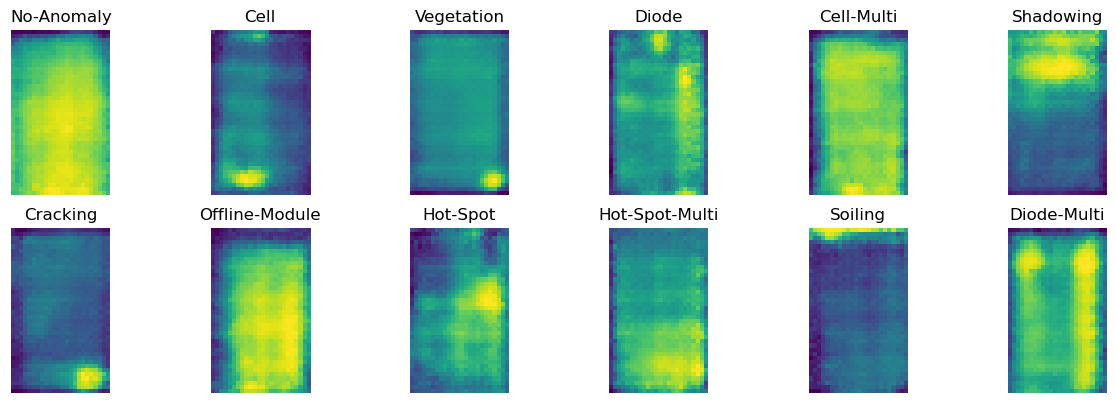

[Epoch 151/500] [D loss: 0.028576521202921867] [G loss: 10.51858139038086]
[Epoch 152/500] [D loss: 0.004647612571716309] [G loss: 7.159428119659424]
[Epoch 153/500] [D loss: 0.03143545985221863] [G loss: 7.0068535804748535]
[Epoch 154/500] [D loss: 0.004289401229470968] [G loss: 6.3829755783081055]
[Epoch 155/500] [D loss: 0.04651876911520958] [G loss: 8.741316795349121]
[Epoch 156/500] [D loss: 0.013949133455753326] [G loss: 7.829861164093018]
[Epoch 157/500] [D loss: 0.25449737906455994] [G loss: 13.240647315979004]
[Epoch 158/500] [D loss: 0.004708436317741871] [G loss: 5.894528865814209]
[Epoch 159/500] [D loss: 0.052231669425964355] [G loss: 16.729158401489258]
[Epoch 160/500] [D loss: 0.00186951644718647] [G loss: 5.91140604019165]


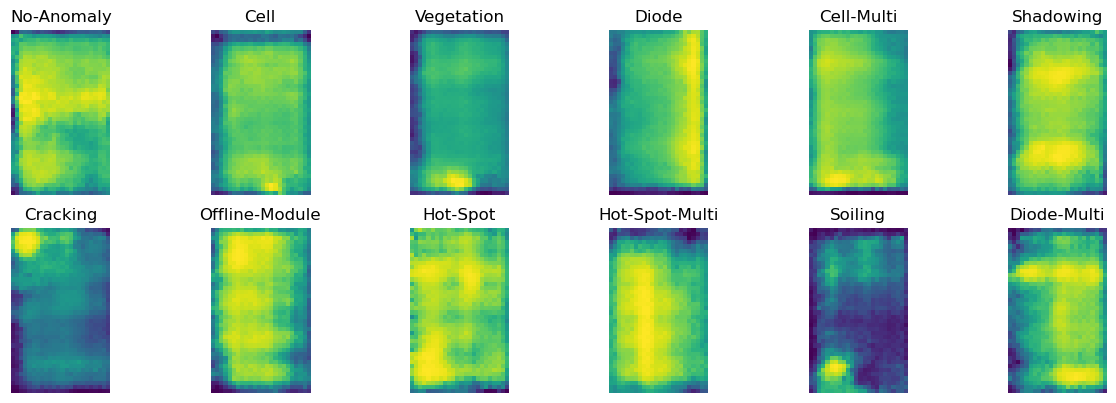

[Epoch 161/500] [D loss: 0.00489842751994729] [G loss: 6.139652252197266]
[Epoch 162/500] [D loss: 0.0016400013118982315] [G loss: 7.521769046783447]
[Epoch 163/500] [D loss: 0.019917404279112816] [G loss: 8.295429229736328]
[Epoch 164/500] [D loss: 0.05726514384150505] [G loss: 14.165440559387207]
[Epoch 165/500] [D loss: 0.04884202405810356] [G loss: 13.589851379394531]
[Epoch 166/500] [D loss: 0.011462354101240635] [G loss: 7.84768533706665]
[Epoch 167/500] [D loss: 0.0010661090491339564] [G loss: 7.463746070861816]
[Epoch 168/500] [D loss: 0.005313519854098558] [G loss: 6.590090751647949]
[Epoch 169/500] [D loss: 0.008630778640508652] [G loss: 6.2659759521484375]
[Epoch 170/500] [D loss: 0.07562388479709625] [G loss: 11.538240432739258]


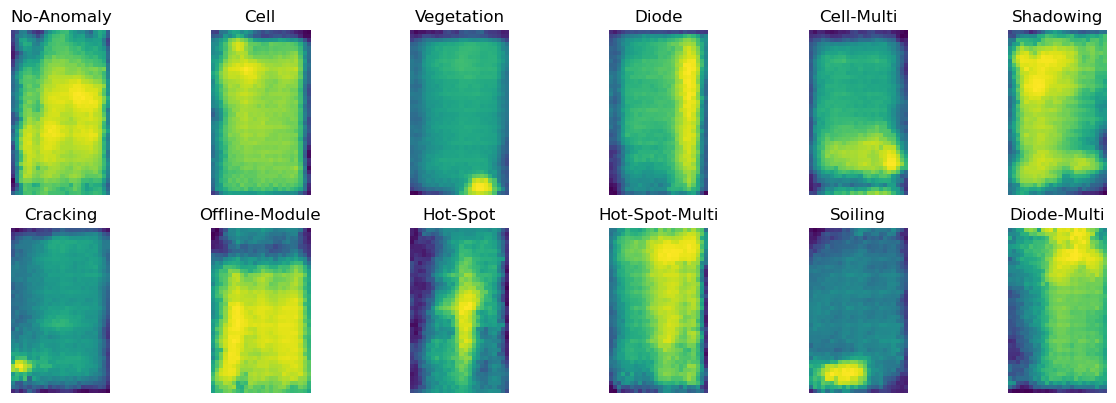

[Epoch 171/500] [D loss: 0.003298717550933361] [G loss: 8.938688278198242]
[Epoch 172/500] [D loss: 0.0017859203508123755] [G loss: 6.215036869049072]
[Epoch 173/500] [D loss: 0.006029929965734482] [G loss: 9.184067726135254]
[Epoch 174/500] [D loss: 0.0008583441958762705] [G loss: 6.386257648468018]
[Epoch 175/500] [D loss: 0.012001379393041134] [G loss: 9.66457748413086]
[Epoch 176/500] [D loss: 0.030177460983395576] [G loss: 12.300647735595703]
[Epoch 177/500] [D loss: 0.0030305993277579546] [G loss: 7.3831562995910645]
[Epoch 178/500] [D loss: 0.00909967627376318] [G loss: 8.79934024810791]
[Epoch 179/500] [D loss: 0.003864761209115386] [G loss: 5.457866668701172]
[Epoch 180/500] [D loss: 0.012880824506282806] [G loss: 8.443873405456543]


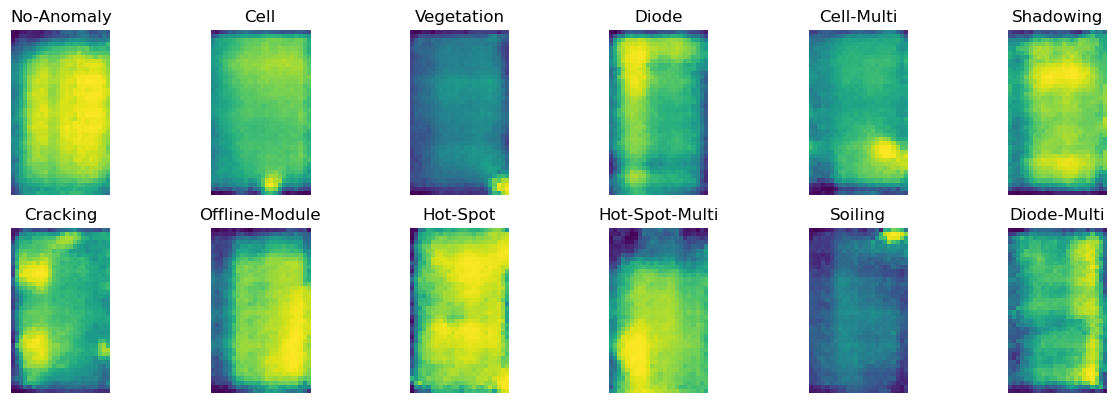

[Epoch 181/500] [D loss: 0.018407417461276054] [G loss: 7.385096549987793]
[Epoch 182/500] [D loss: 0.004077910911291838] [G loss: 5.345356464385986]
[Epoch 183/500] [D loss: 0.0091440100222826] [G loss: 9.716961860656738]
[Epoch 184/500] [D loss: 0.08035138249397278] [G loss: 6.798818588256836]
[Epoch 185/500] [D loss: 0.08934570103883743] [G loss: 12.323403358459473]
[Epoch 186/500] [D loss: 0.11698950827121735] [G loss: 9.05246353149414]
[Epoch 187/500] [D loss: 0.008861428126692772] [G loss: 7.92876672744751]
[Epoch 188/500] [D loss: 0.003827817505225539] [G loss: 6.396780014038086]
[Epoch 189/500] [D loss: 0.02412458136677742] [G loss: 11.795062065124512]
[Epoch 190/500] [D loss: 0.0025189470034092665] [G loss: 5.669379711151123]


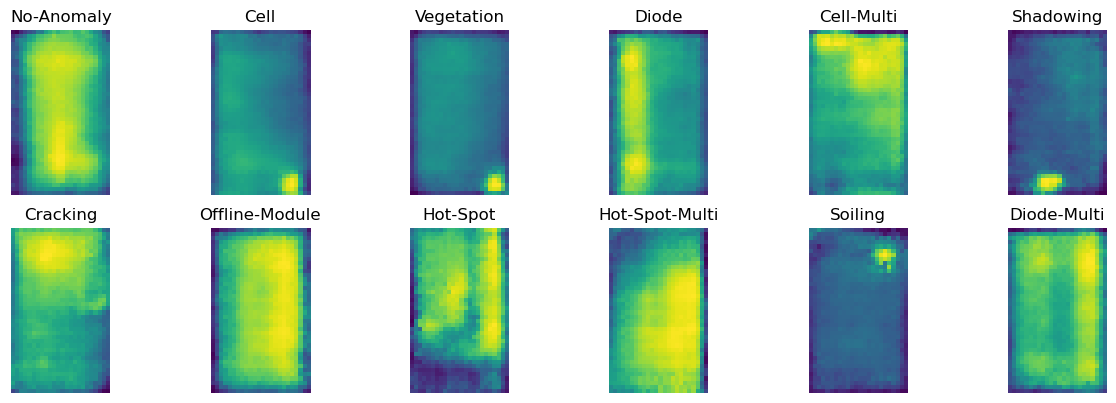

[Epoch 191/500] [D loss: 0.003038588911294937] [G loss: 5.575757026672363]
[Epoch 192/500] [D loss: 0.0001016302703646943] [G loss: 8.761589050292969]
[Epoch 193/500] [D loss: 0.0008353895973414183] [G loss: 6.5932745933532715]
[Epoch 194/500] [D loss: 0.00952424667775631] [G loss: 5.693545341491699]
[Epoch 195/500] [D loss: 6.83224861859344e-05] [G loss: 9.44884204864502]
[Epoch 196/500] [D loss: 0.03122617118060589] [G loss: 7.388847351074219]
[Epoch 197/500] [D loss: 0.005288976244628429] [G loss: 8.28044319152832]
[Epoch 198/500] [D loss: 0.011956501752138138] [G loss: 7.222687244415283]
[Epoch 199/500] [D loss: 0.003228304907679558] [G loss: 5.873917579650879]
[Epoch 200/500] [D loss: 0.14770621061325073] [G loss: 8.399991989135742]


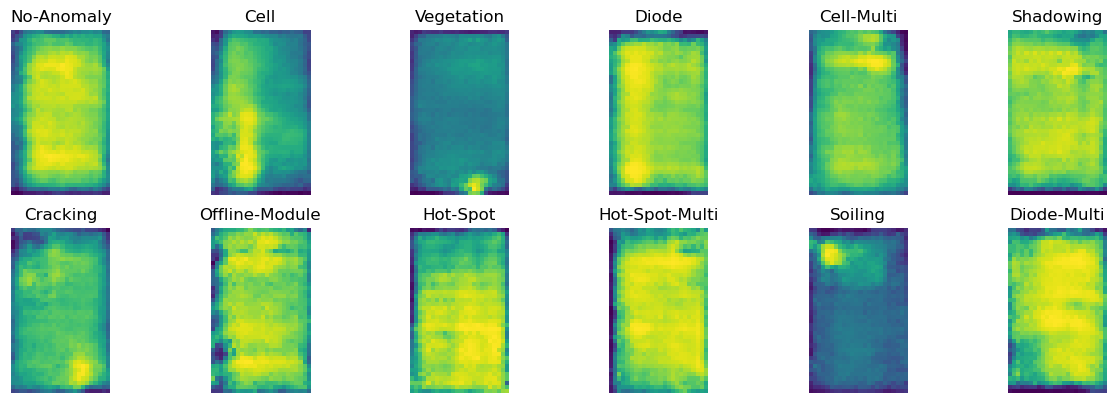

[Epoch 201/500] [D loss: 0.07864681631326675] [G loss: 11.685503959655762]
[Epoch 202/500] [D loss: 1.9343969821929932] [G loss: 6.4833550453186035]
[Epoch 203/500] [D loss: 0.011014411225914955] [G loss: 6.931260108947754]
[Epoch 204/500] [D loss: 0.002641439437866211] [G loss: 5.863724708557129]
[Epoch 205/500] [D loss: 0.038846518844366074] [G loss: 7.780360221862793]
[Epoch 206/500] [D loss: 0.0057232012040913105] [G loss: 6.7020063400268555]
[Epoch 207/500] [D loss: 0.045508310198783875] [G loss: 9.287191390991211]
[Epoch 208/500] [D loss: 0.014135931618511677] [G loss: 6.199270725250244]
[Epoch 209/500] [D loss: 0.0210530087351799] [G loss: 6.960087299346924]
[Epoch 210/500] [D loss: 0.00617827195674181] [G loss: 6.385354042053223]


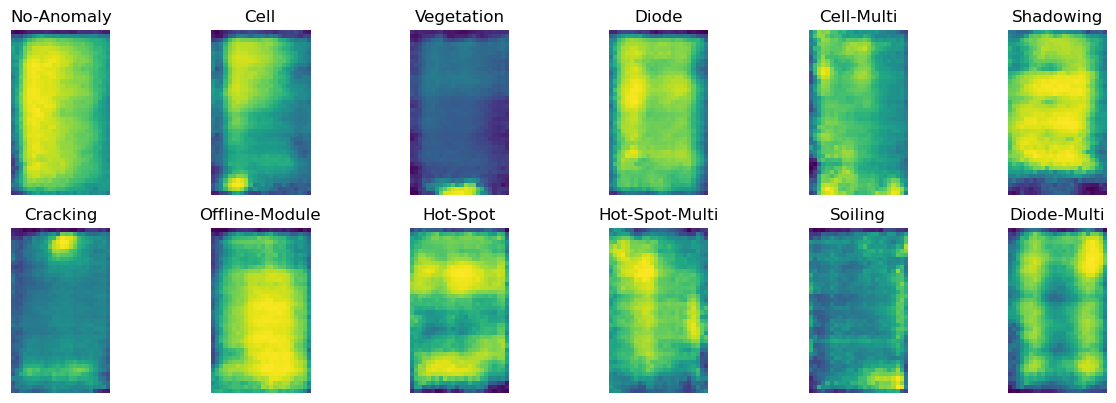

[Epoch 211/500] [D loss: 0.004014717414975166] [G loss: 7.253056526184082]
[Epoch 212/500] [D loss: 0.09323078393936157] [G loss: 10.368401527404785]
[Epoch 213/500] [D loss: 0.022121986374258995] [G loss: 11.780634880065918]
[Epoch 214/500] [D loss: 0.006859904620796442] [G loss: 5.905167102813721]
[Epoch 215/500] [D loss: 0.0020437531638890505] [G loss: 6.827548503875732]
[Epoch 216/500] [D loss: 0.0015201173955574632] [G loss: 6.959869384765625]
[Epoch 217/500] [D loss: 0.029332121834158897] [G loss: 11.14373779296875]
[Epoch 218/500] [D loss: 0.029424846172332764] [G loss: 12.787097930908203]
[Epoch 219/500] [D loss: 0.002207248006016016] [G loss: 6.405866622924805]
[Epoch 220/500] [D loss: 0.0020861062221229076] [G loss: 7.968451023101807]


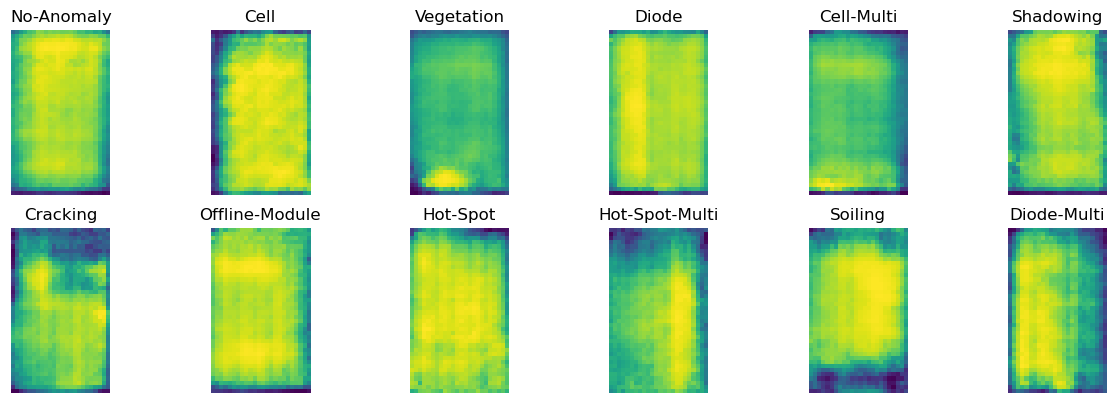

[Epoch 221/500] [D loss: 0.012867767363786697] [G loss: 6.155969142913818]
[Epoch 222/500] [D loss: 0.0017700294265523553] [G loss: 7.69597053527832]
[Epoch 223/500] [D loss: 0.04088699072599411] [G loss: 6.534124851226807]
[Epoch 224/500] [D loss: 0.8091099858283997] [G loss: 3.8167076110839844]
[Epoch 225/500] [D loss: 0.0030792062170803547] [G loss: 5.640876293182373]
[Epoch 226/500] [D loss: 0.005352724809199572] [G loss: 5.405133247375488]
[Epoch 227/500] [D loss: 0.02543588913977146] [G loss: 8.106983184814453]
[Epoch 228/500] [D loss: 0.003126024268567562] [G loss: 10.1674165725708]
[Epoch 229/500] [D loss: 0.003227054141461849] [G loss: 7.074040412902832]
[Epoch 230/500] [D loss: 0.22400888800621033] [G loss: 5.477648735046387]


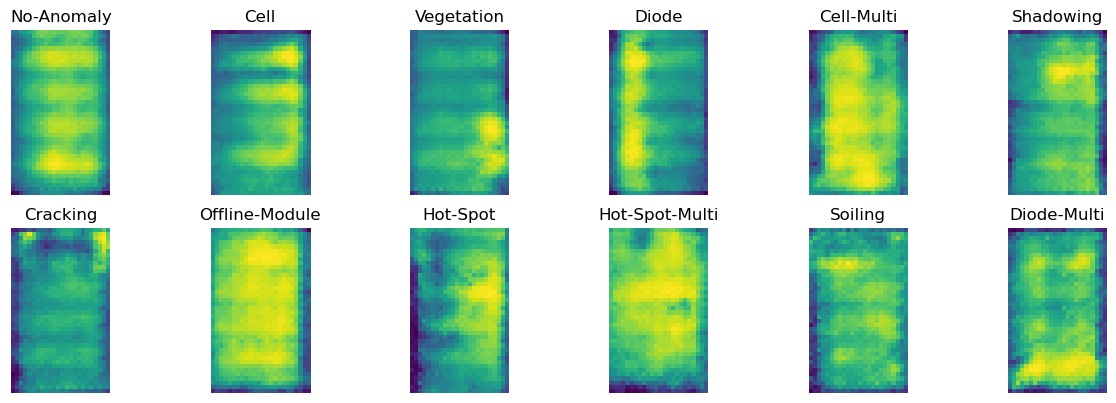

[Epoch 231/500] [D loss: 0.02457505650818348] [G loss: 8.280414581298828]
[Epoch 232/500] [D loss: 0.0034204849507659674] [G loss: 6.987665176391602]
[Epoch 233/500] [D loss: 0.01617477275431156] [G loss: 12.352497100830078]
[Epoch 234/500] [D loss: 0.26053863763809204] [G loss: 5.837045669555664]
[Epoch 235/500] [D loss: 0.004166832193732262] [G loss: 5.8315839767456055]
[Epoch 236/500] [D loss: 0.0159923005849123] [G loss: 9.361152648925781]
[Epoch 237/500] [D loss: 0.09118372201919556] [G loss: 6.815413475036621]
[Epoch 238/500] [D loss: 0.01864231750369072] [G loss: 6.87576150894165]
[Epoch 239/500] [D loss: 0.0022676377557218075] [G loss: 6.863168716430664]
[Epoch 240/500] [D loss: 0.0033492681104689837] [G loss: 6.446103096008301]


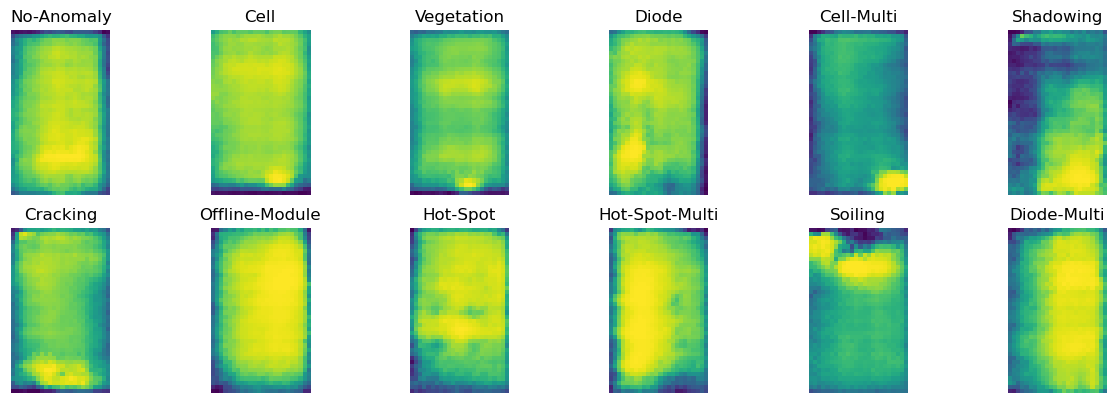

[Epoch 241/500] [D loss: 0.008094856515526772] [G loss: 5.554294109344482]
[Epoch 242/500] [D loss: 0.37815573811531067] [G loss: 1.4569222927093506]
[Epoch 243/500] [D loss: 0.015907760709524155] [G loss: 4.937183856964111]
[Epoch 244/500] [D loss: 0.004041268490254879] [G loss: 7.549853801727295]
[Epoch 245/500] [D loss: 0.012411796487867832] [G loss: 6.595248222351074]
[Epoch 246/500] [D loss: 0.01919676922261715] [G loss: 6.289584636688232]
[Epoch 247/500] [D loss: 0.07023702561855316] [G loss: 8.28718090057373]
[Epoch 248/500] [D loss: 0.003277609823271632] [G loss: 5.454614162445068]
[Epoch 249/500] [D loss: 0.001727420836687088] [G loss: 6.630993843078613]
[Epoch 250/500] [D loss: 0.0024968290235847235] [G loss: 7.237296104431152]


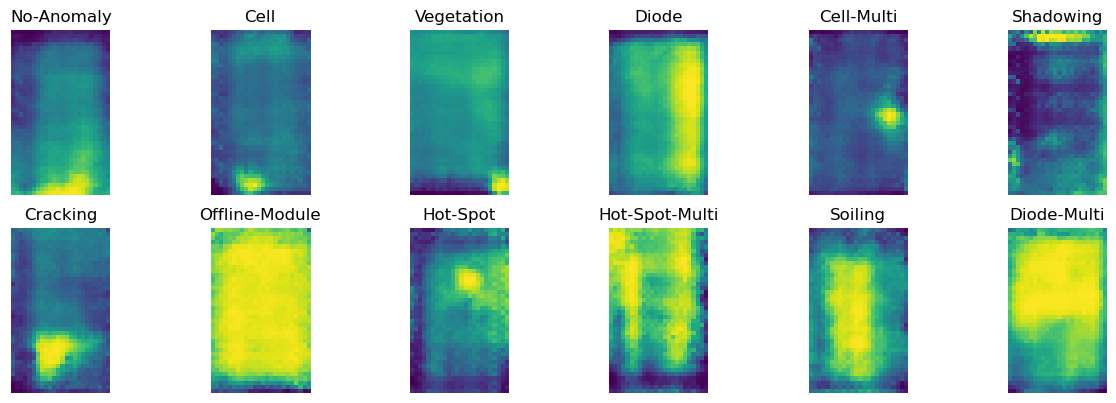

[Epoch 251/500] [D loss: 0.019102793186903] [G loss: 6.355781555175781]
[Epoch 252/500] [D loss: 0.00412839837372303] [G loss: 5.5204548835754395]
[Epoch 253/500] [D loss: 0.022475339472293854] [G loss: 10.416438102722168]
[Epoch 254/500] [D loss: 0.049101877957582474] [G loss: 10.323902130126953]
[Epoch 255/500] [D loss: 0.008166423998773098] [G loss: 4.661787986755371]
[Epoch 256/500] [D loss: 0.009957503527402878] [G loss: 5.807509422302246]
[Epoch 257/500] [D loss: 0.00016200858226511627] [G loss: 8.150545120239258]
[Epoch 258/500] [D loss: 0.0014325156807899475] [G loss: 6.017232894897461]
[Epoch 259/500] [D loss: 3.4718456268310547] [G loss: 5.575505256652832]
[Epoch 260/500] [D loss: 0.053176671266555786] [G loss: 6.015275478363037]


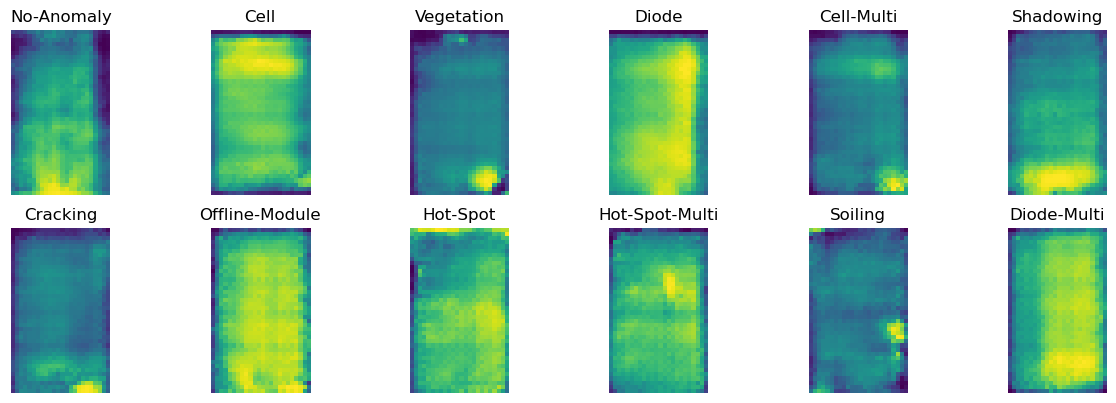

[Epoch 261/500] [D loss: 0.003763756016269326] [G loss: 5.194483757019043]
[Epoch 262/500] [D loss: 3.45922589302063] [G loss: 3.834700584411621]
[Epoch 263/500] [D loss: 0.004620922263711691] [G loss: 4.977696895599365]
[Epoch 264/500] [D loss: 0.01326614897698164] [G loss: 6.4335222244262695]
[Epoch 265/500] [D loss: 0.0010466881794854999] [G loss: 7.733502388000488]
[Epoch 266/500] [D loss: 0.006029576063156128] [G loss: 5.409271240234375]
[Epoch 267/500] [D loss: 0.18461529910564423] [G loss: 18.62287712097168]
[Epoch 268/500] [D loss: 0.013707851991057396] [G loss: 7.762272834777832]
[Epoch 269/500] [D loss: 0.07056014239788055] [G loss: 10.578434944152832]
[Epoch 270/500] [D loss: 0.0030235634185373783] [G loss: 5.853246688842773]


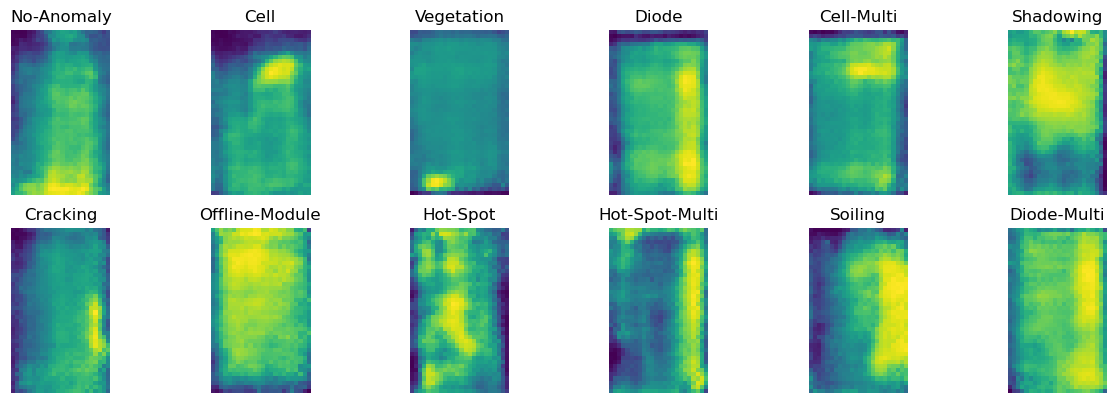

[Epoch 271/500] [D loss: 0.012092478573322296] [G loss: 5.462606430053711]
[Epoch 272/500] [D loss: 0.000468735204776749] [G loss: 7.019102573394775]
[Epoch 273/500] [D loss: 1.4257780313491821] [G loss: 7.001911640167236]
[Epoch 274/500] [D loss: 0.0043322136625647545] [G loss: 8.114022254943848]
[Epoch 275/500] [D loss: 0.23980343341827393] [G loss: 6.163252353668213]
[Epoch 276/500] [D loss: 0.02322990633547306] [G loss: 8.652214050292969]
[Epoch 277/500] [D loss: 0.036517444998025894] [G loss: 6.852725028991699]
[Epoch 278/500] [D loss: 0.014975526370108128] [G loss: 5.653622627258301]
[Epoch 279/500] [D loss: 1.4182112949290282e-11] [G loss: 22.81426429748535]
[Epoch 280/500] [D loss: 0.008312101475894451] [G loss: 8.080526351928711]


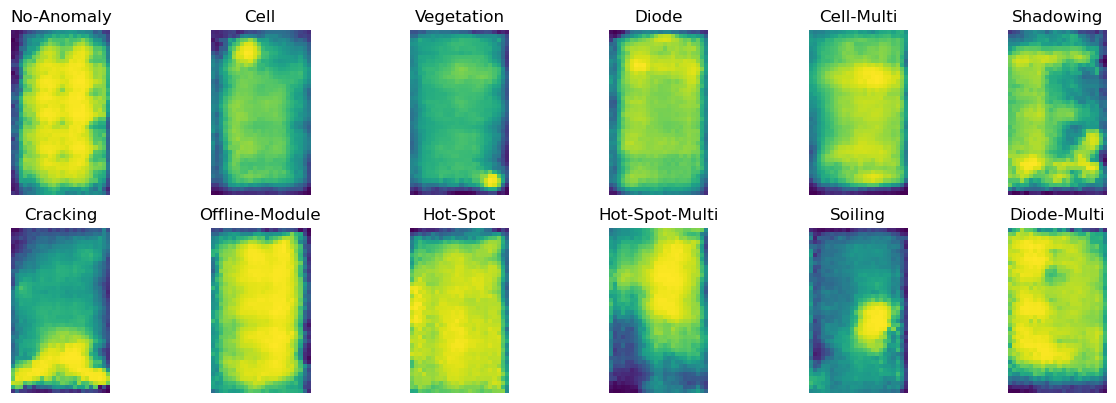

[Epoch 281/500] [D loss: 0.004613025579601526] [G loss: 5.499018669128418]
[Epoch 282/500] [D loss: 0.021872244775295258] [G loss: 4.516926288604736]
[Epoch 283/500] [D loss: 0.000669286004267633] [G loss: 7.049200534820557]
[Epoch 284/500] [D loss: 0.009093282744288445] [G loss: 6.660548686981201]
[Epoch 285/500] [D loss: 0.003617376321926713] [G loss: 5.1134490966796875]
[Epoch 286/500] [D loss: 0.0025534487795084715] [G loss: 6.322821140289307]
[Epoch 287/500] [D loss: 0.005049487575888634] [G loss: 5.564367294311523]
[Epoch 288/500] [D loss: 0.026037422940135002] [G loss: 6.301514148712158]
[Epoch 289/500] [D loss: 0.4905411899089813] [G loss: 10.453184127807617]
[Epoch 290/500] [D loss: 0.004934200085699558] [G loss: 6.192206859588623]


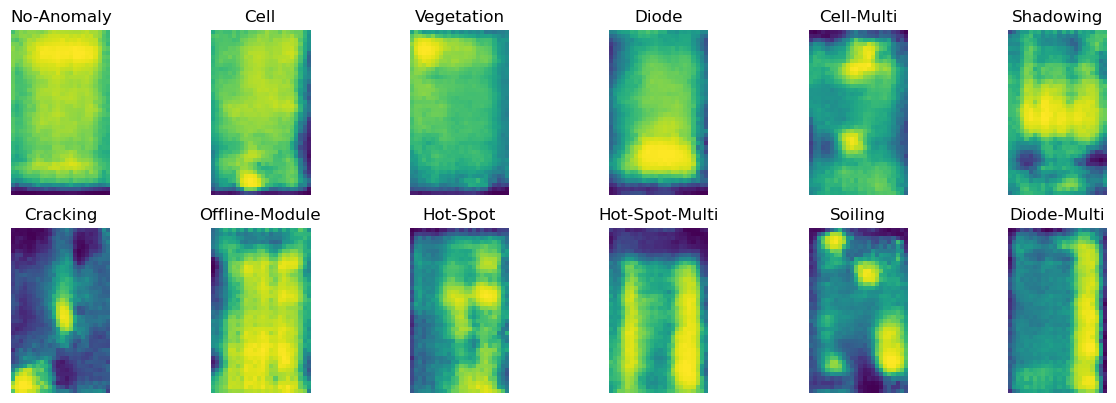

[Epoch 291/500] [D loss: 0.004453497007489204] [G loss: 5.692637920379639]
[Epoch 292/500] [D loss: 0.001918408670462668] [G loss: 6.9655585289001465]
[Epoch 293/500] [D loss: 0.006905237678438425] [G loss: 6.81399393081665]
[Epoch 294/500] [D loss: 0.015899743884801865] [G loss: 8.158699989318848]
[Epoch 295/500] [D loss: 0.0005940263508819044] [G loss: 6.919885158538818]
[Epoch 296/500] [D loss: 0.0008335181046277285] [G loss: 6.357903480529785]
[Epoch 297/500] [D loss: 0.010901998728513718] [G loss: 7.283771991729736]
[Epoch 298/500] [D loss: 0.005947803147137165] [G loss: 4.90701961517334]
[Epoch 299/500] [D loss: 0.017833799123764038] [G loss: 7.2972846031188965]
[Epoch 300/500] [D loss: 0.05842859297990799] [G loss: 7.7368292808532715]


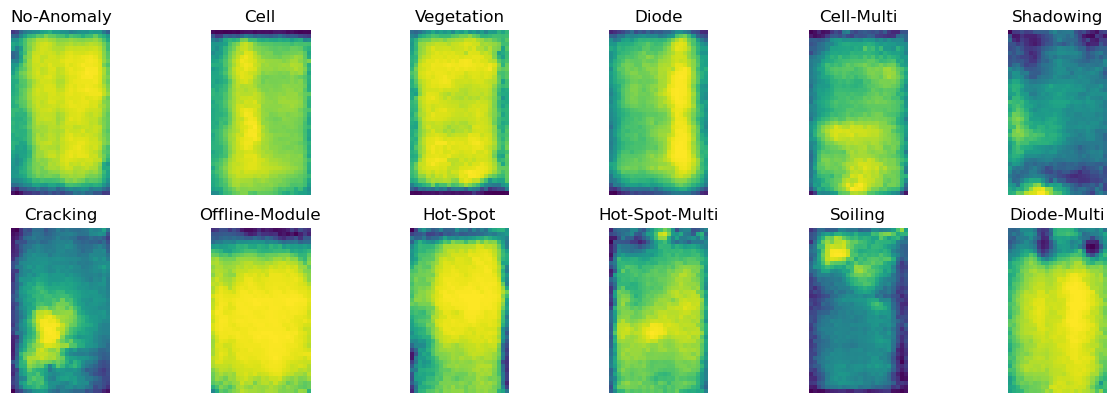

[Epoch 301/500] [D loss: 2.255215644836426] [G loss: 7.993257522583008]
[Epoch 302/500] [D loss: 0.00303968065418303] [G loss: 6.006397724151611]
[Epoch 303/500] [D loss: 0.0002894370991270989] [G loss: 8.181532859802246]
[Epoch 304/500] [D loss: 0.010556616820394993] [G loss: 6.18580436706543]
[Epoch 305/500] [D loss: 0.0012130908435210586] [G loss: 6.901722431182861]
[Epoch 306/500] [D loss: 0.015006048604846] [G loss: 6.884636878967285]
[Epoch 307/500] [D loss: 0.0918462797999382] [G loss: 4.797697067260742]
[Epoch 308/500] [D loss: 0.0019240060355514288] [G loss: 6.040150165557861]
[Epoch 309/500] [D loss: 0.034440964460372925] [G loss: 5.982974529266357]
[Epoch 310/500] [D loss: 0.0023465934209525585] [G loss: 5.718958854675293]


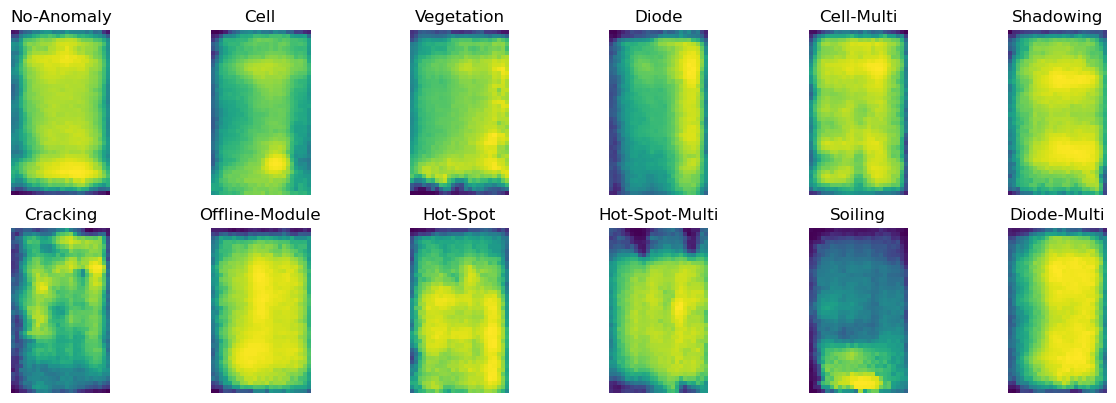

[Epoch 311/500] [D loss: 0.010321437381207943] [G loss: 6.370175361633301]
[Epoch 312/500] [D loss: 0.01716257631778717] [G loss: 8.375746726989746]
[Epoch 313/500] [D loss: 0.001827669213525951] [G loss: 5.762592792510986]
[Epoch 314/500] [D loss: 0.0014389891875907779] [G loss: 6.568072319030762]
[Epoch 315/500] [D loss: 0.00494864396750927] [G loss: 4.936893463134766]
[Epoch 316/500] [D loss: 0.10191197693347931] [G loss: 9.556303024291992]
[Epoch 317/500] [D loss: 0.0033788387663662434] [G loss: 5.569644451141357]
[Epoch 318/500] [D loss: 0.015549441799521446] [G loss: 6.27478551864624]
[Epoch 319/500] [D loss: 0.3393222689628601] [G loss: 8.76469898223877]
[Epoch 320/500] [D loss: 0.0019635099451988935] [G loss: 6.020891189575195]


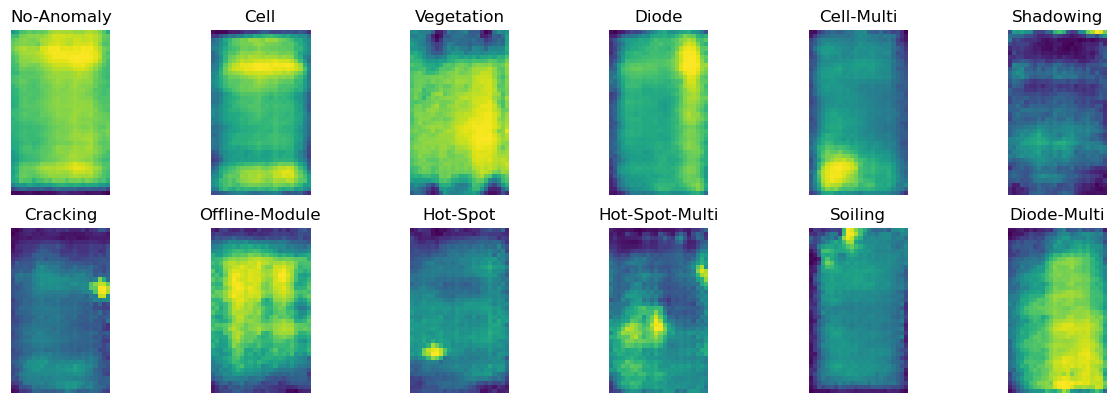

[Epoch 321/500] [D loss: 0.051159583032131195] [G loss: 7.248688220977783]
[Epoch 322/500] [D loss: 0.0009396406239829957] [G loss: 6.556253433227539]
[Epoch 323/500] [D loss: 0.012348060496151447] [G loss: 8.053762435913086]
[Epoch 324/500] [D loss: 0.007027039770036936] [G loss: 11.743406295776367]
[Epoch 325/500] [D loss: 0.005889349617063999] [G loss: 4.748634338378906]
[Epoch 326/500] [D loss: 0.0037972957361489534] [G loss: 5.71900749206543]
[Epoch 327/500] [D loss: 0.01985599473118782] [G loss: 5.380008220672607]
[Epoch 328/500] [D loss: 0.002206927863880992] [G loss: 6.949927806854248]
[Epoch 329/500] [D loss: 0.008781345561146736] [G loss: 7.888683319091797]
[Epoch 330/500] [D loss: 0.005255984142422676] [G loss: 5.422555923461914]


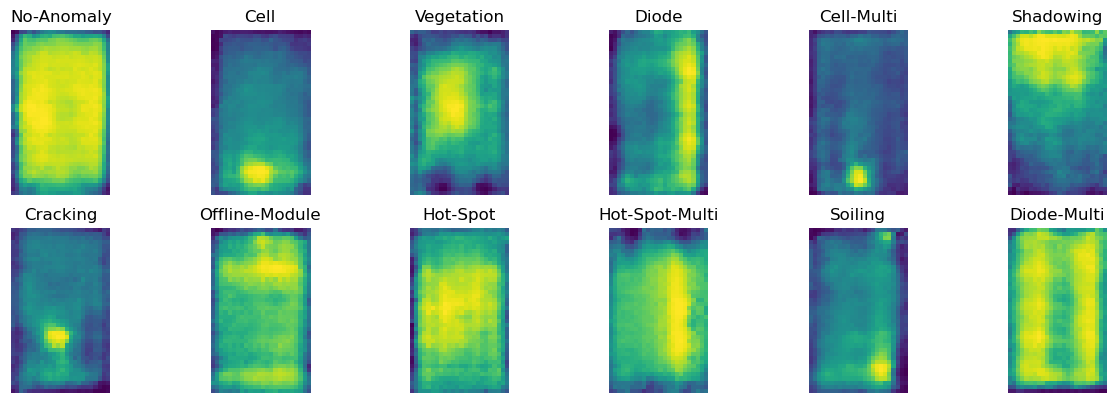

[Epoch 331/500] [D loss: 0.003247253829613328] [G loss: 5.1603569984436035]
[Epoch 332/500] [D loss: 0.005418851040303707] [G loss: 5.986371040344238]
[Epoch 333/500] [D loss: 0.06453856825828552] [G loss: 8.602970123291016]
[Epoch 334/500] [D loss: 0.008001529611647129] [G loss: 4.982980728149414]
[Epoch 335/500] [D loss: 0.010655682533979416] [G loss: 4.872766971588135]
[Epoch 336/500] [D loss: 0.004392391070723534] [G loss: 6.173858165740967]
[Epoch 337/500] [D loss: 0.008004339411854744] [G loss: 5.244065284729004]
[Epoch 338/500] [D loss: 0.020906897261738777] [G loss: 8.051063537597656]
[Epoch 339/500] [D loss: 0.011310174129903316] [G loss: 6.471429347991943]
[Epoch 340/500] [D loss: 0.0033981557935476303] [G loss: 5.314208984375]


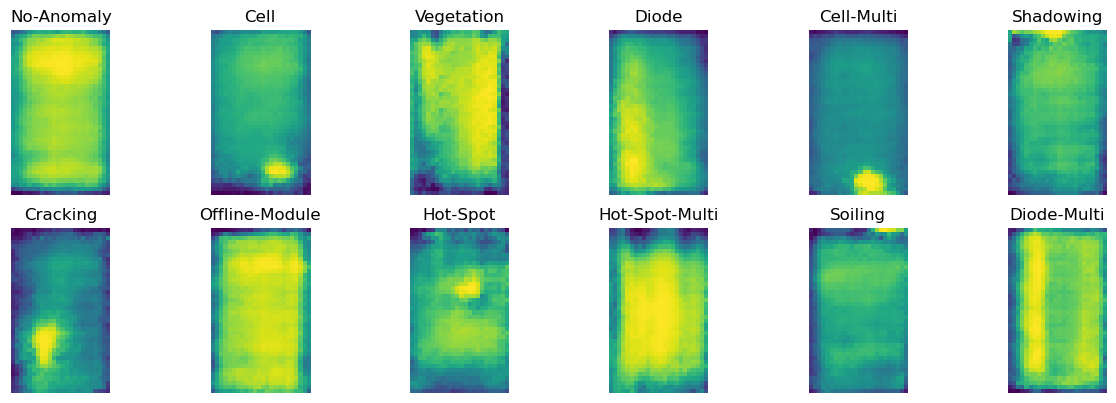

[Epoch 341/500] [D loss: 0.005974617786705494] [G loss: 5.144184112548828]
[Epoch 342/500] [D loss: 0.0003335518413223326] [G loss: 7.385025501251221]
[Epoch 343/500] [D loss: 0.017246421426534653] [G loss: 10.126728057861328]
[Epoch 344/500] [D loss: 0.037253957241773605] [G loss: 14.55148983001709]
[Epoch 345/500] [D loss: 0.0013415816938504577] [G loss: 6.619462490081787]
[Epoch 346/500] [D loss: 0.02862521819770336] [G loss: 5.928736209869385]
[Epoch 347/500] [D loss: 9.353180757898372e-06] [G loss: 11.47506332397461]
[Epoch 348/500] [D loss: 0.0002071197668556124] [G loss: 8.067172050476074]
[Epoch 349/500] [D loss: 0.0019625427667051554] [G loss: 6.253068923950195]
[Epoch 350/500] [D loss: 0.009007517248392105] [G loss: 7.16603946685791]


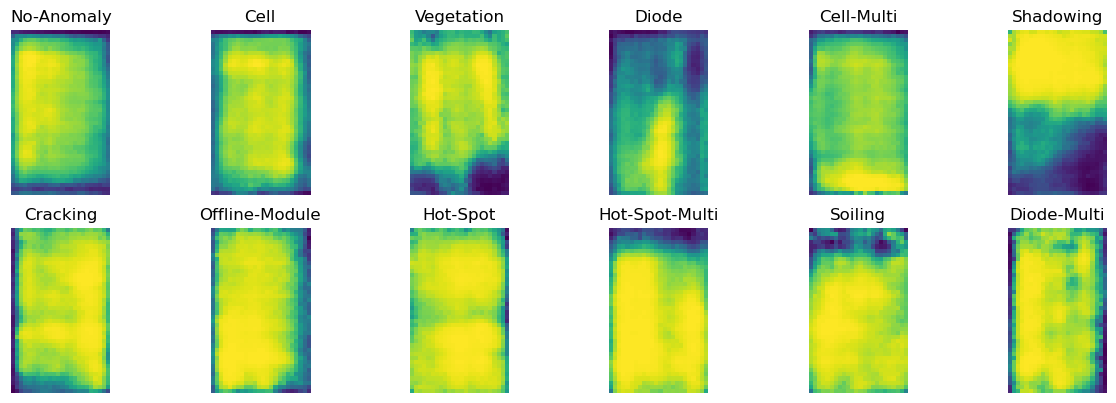

[Epoch 351/500] [D loss: 0.02750209905207157] [G loss: 6.456394672393799]
[Epoch 352/500] [D loss: 0.0034318326506763697] [G loss: 6.639265537261963]
[Epoch 353/500] [D loss: 0.004797011148184538] [G loss: 5.152810096740723]
[Epoch 354/500] [D loss: 0.002619450446218252] [G loss: 5.950083255767822]
[Epoch 355/500] [D loss: 0.0022290139459073544] [G loss: 6.012916088104248]
[Epoch 356/500] [D loss: 0.010882512666285038] [G loss: 6.864861488342285]
[Epoch 357/500] [D loss: 0.002166228136047721] [G loss: 6.189529895782471]
[Epoch 358/500] [D loss: 0.00630537373945117] [G loss: 4.666626453399658]
[Epoch 359/500] [D loss: 0.0029425076209008694] [G loss: 5.651904106140137]
[Epoch 360/500] [D loss: 1.3992588719702326e-05] [G loss: 12.21193790435791]


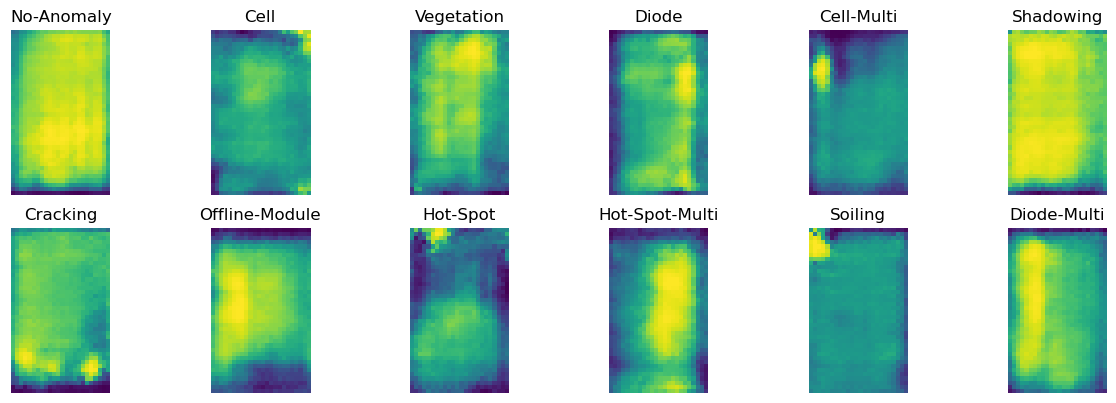

[Epoch 361/500] [D loss: 0.0009644757956266403] [G loss: 6.21930456161499]
[Epoch 362/500] [D loss: 0.007893478497862816] [G loss: 6.2030558586120605]
[Epoch 363/500] [D loss: 0.0329180546104908] [G loss: 13.555773735046387]
[Epoch 364/500] [D loss: 0.002293782541528344] [G loss: 9.171015739440918]
[Epoch 365/500] [D loss: 0.005749613977968693] [G loss: 5.353877067565918]
[Epoch 366/500] [D loss: 0.002889984752982855] [G loss: 5.856213569641113]
[Epoch 367/500] [D loss: 0.08931519836187363] [G loss: 8.14913558959961]
[Epoch 368/500] [D loss: 0.016785573214292526] [G loss: 6.11466121673584]
[Epoch 369/500] [D loss: 0.021577980369329453] [G loss: 10.577203750610352]
[Epoch 370/500] [D loss: 9.246551780961454e-05] [G loss: 8.606642723083496]


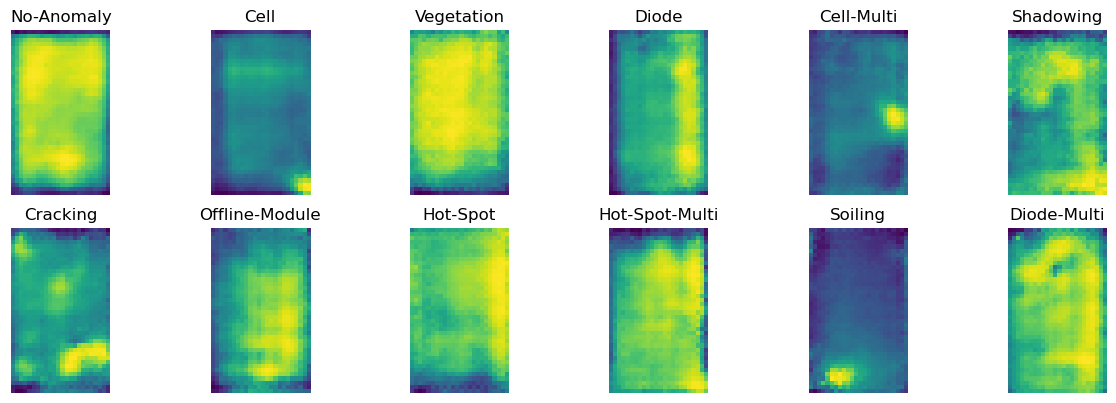

[Epoch 371/500] [D loss: 0.0005403998657129705] [G loss: 7.419663906097412]
[Epoch 372/500] [D loss: 0.0005572040681727231] [G loss: 7.542023658752441]
[Epoch 373/500] [D loss: 0.03292881324887276] [G loss: 6.716439723968506]
[Epoch 374/500] [D loss: 0.01235252432525158] [G loss: 5.5506911277771]
[Epoch 375/500] [D loss: 0.005318323615938425] [G loss: 7.53450345993042]
[Epoch 376/500] [D loss: 0.007387194316834211] [G loss: 5.52079439163208]
[Epoch 377/500] [D loss: 0.6038028597831726] [G loss: 11.473828315734863]
[Epoch 378/500] [D loss: 0.013310342095792294] [G loss: 7.093935966491699]
[Epoch 379/500] [D loss: 0.060879986733198166] [G loss: 8.19600772857666]
[Epoch 380/500] [D loss: 0.00012824576697312295] [G loss: 8.075566291809082]


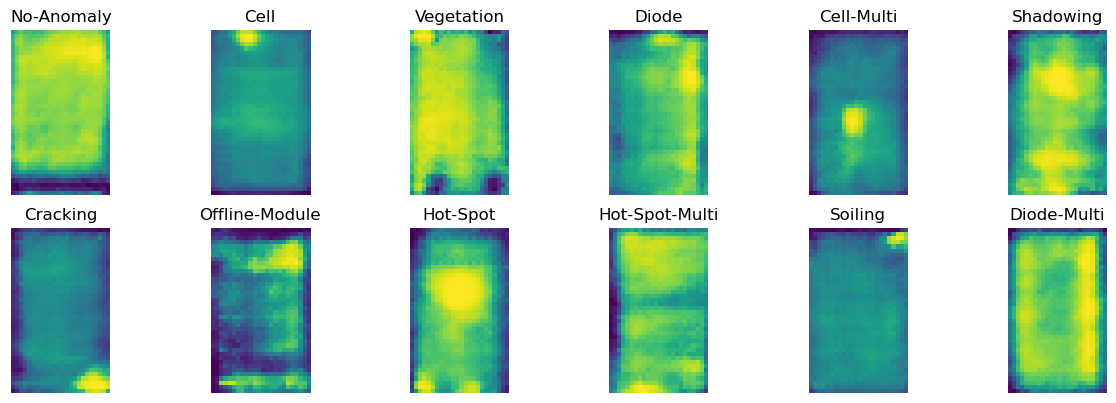

[Epoch 381/500] [D loss: 0.004691870883107185] [G loss: 6.63270378112793]
[Epoch 382/500] [D loss: 0.010432075709104538] [G loss: 7.138097763061523]
[Epoch 383/500] [D loss: 0.03863060846924782] [G loss: 5.911645889282227]
[Epoch 384/500] [D loss: 0.004481493029743433] [G loss: 5.760166168212891]
[Epoch 385/500] [D loss: 0.0002729552215896547] [G loss: 9.244096755981445]
[Epoch 386/500] [D loss: 0.009800831787288189] [G loss: 5.292703151702881]
[Epoch 387/500] [D loss: 0.001470800954848528] [G loss: 5.923564434051514]
[Epoch 388/500] [D loss: 1.2301075458526611] [G loss: 0.0025882809422910213]
[Epoch 389/500] [D loss: 0.0015498652355745435] [G loss: 5.981464385986328]
[Epoch 390/500] [D loss: 0.11947457492351532] [G loss: 12.730659484863281]


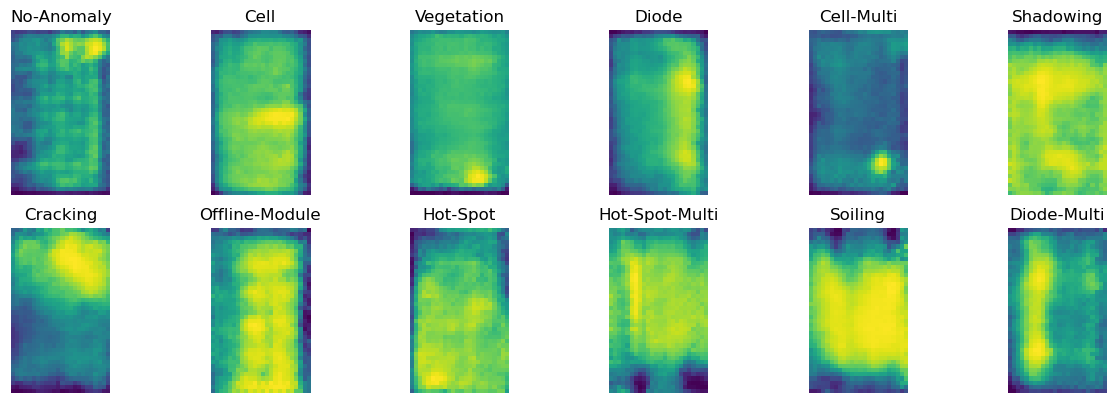

[Epoch 391/500] [D loss: 0.09973371773958206] [G loss: 9.531465530395508]
[Epoch 392/500] [D loss: 0.018112435936927795] [G loss: 4.486955165863037]
[Epoch 393/500] [D loss: 0.011701100505888462] [G loss: 7.862123966217041]
[Epoch 394/500] [D loss: 0.2670016586780548] [G loss: 10.616573333740234]
[Epoch 395/500] [D loss: 0.0006042284076102078] [G loss: 6.927603244781494]
[Epoch 396/500] [D loss: 0.0017174354288727045] [G loss: 5.965975761413574]
[Epoch 397/500] [D loss: 0.00568794971331954] [G loss: 6.430078506469727]
[Epoch 398/500] [D loss: 0.017519917339086533] [G loss: 5.148136615753174]
[Epoch 399/500] [D loss: 0.9484605193138123] [G loss: 0.006795855704694986]
[Epoch 400/500] [D loss: 2.307079553604126] [G loss: 5.17515230178833]


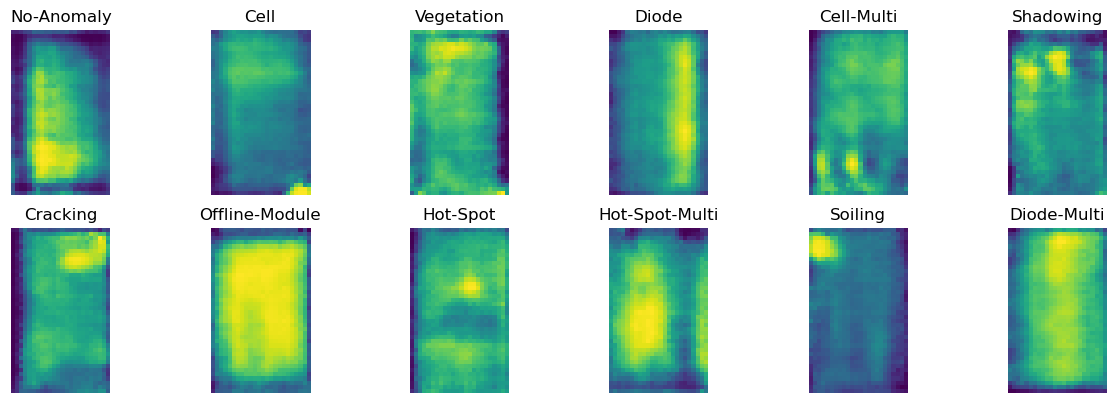

[Epoch 401/500] [D loss: 0.023007437586784363] [G loss: 5.44553279876709]
[Epoch 402/500] [D loss: 0.011221818625926971] [G loss: 8.259276390075684]
[Epoch 403/500] [D loss: 0.008726411499083042] [G loss: 10.3621244430542]
[Epoch 404/500] [D loss: 0.041072092950344086] [G loss: 5.319386959075928]
[Epoch 405/500] [D loss: 0.021258879452943802] [G loss: 10.64190673828125]
[Epoch 406/500] [D loss: 0.0024534945841878653] [G loss: 6.248142719268799]
[Epoch 407/500] [D loss: 0.012021195143461227] [G loss: 7.562033653259277]
[Epoch 408/500] [D loss: 0.00623714504763484] [G loss: 5.279623031616211]
[Epoch 409/500] [D loss: 0.13958223164081573] [G loss: 7.535215377807617]
[Epoch 410/500] [D loss: 0.022028272971510887] [G loss: 5.155618190765381]


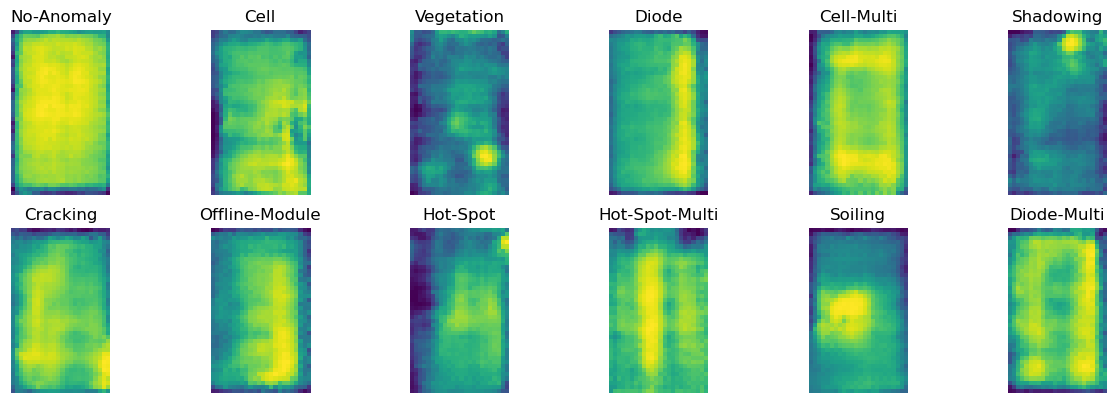

[Epoch 411/500] [D loss: 0.00030674904701299965] [G loss: 7.486656665802002]
[Epoch 412/500] [D loss: 0.004519291687756777] [G loss: 6.132165908813477]
[Epoch 413/500] [D loss: 0.06479814648628235] [G loss: 6.809456825256348]
[Epoch 414/500] [D loss: 0.0149485282599926] [G loss: 5.2127838134765625]
[Epoch 415/500] [D loss: 0.004968767520040274] [G loss: 4.694119453430176]
[Epoch 416/500] [D loss: 0.0025095080491155386] [G loss: 5.867944717407227]
[Epoch 417/500] [D loss: 0.02097969315946102] [G loss: 5.231281757354736]
[Epoch 418/500] [D loss: 0.015814058482646942] [G loss: 8.16915512084961]
[Epoch 419/500] [D loss: 0.06379494071006775] [G loss: 9.328800201416016]
[Epoch 420/500] [D loss: 0.007563489489257336] [G loss: 4.3025898933410645]


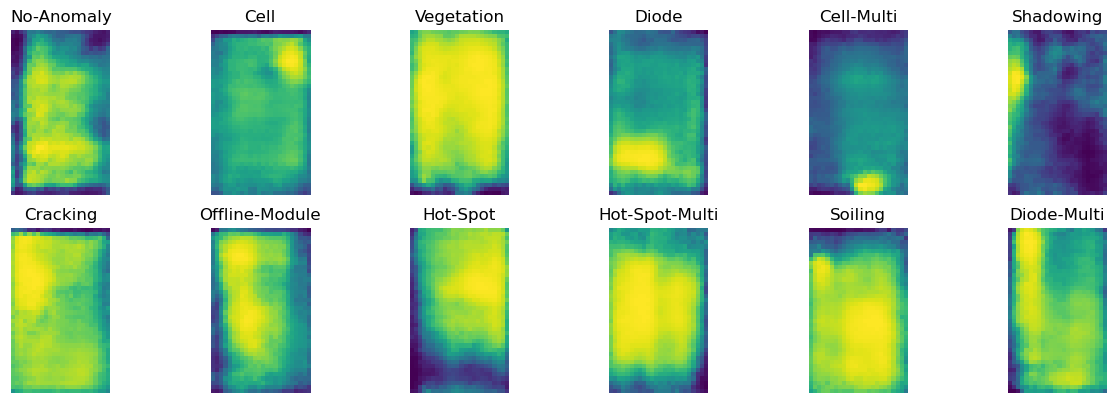

[Epoch 421/500] [D loss: 0.04089554026722908] [G loss: 8.931961059570312]
[Epoch 422/500] [D loss: 0.014606407843530178] [G loss: 3.836524486541748]
[Epoch 423/500] [D loss: 0.003008435480296612] [G loss: 5.376800060272217]
[Epoch 424/500] [D loss: 0.001519911689683795] [G loss: 6.43381929397583]
[Epoch 425/500] [D loss: 0.2722199857234955] [G loss: 4.528886318206787]
[Epoch 426/500] [D loss: 0.05484975129365921] [G loss: 12.423517227172852]
[Epoch 427/500] [D loss: 0.0008854243787936866] [G loss: 8.296492576599121]
[Epoch 428/500] [D loss: 0.015052719973027706] [G loss: 4.583571910858154]
[Epoch 429/500] [D loss: 0.000670493405777961] [G loss: 6.903247833251953]
[Epoch 430/500] [D loss: 0.00014544252189807594] [G loss: 8.205850601196289]


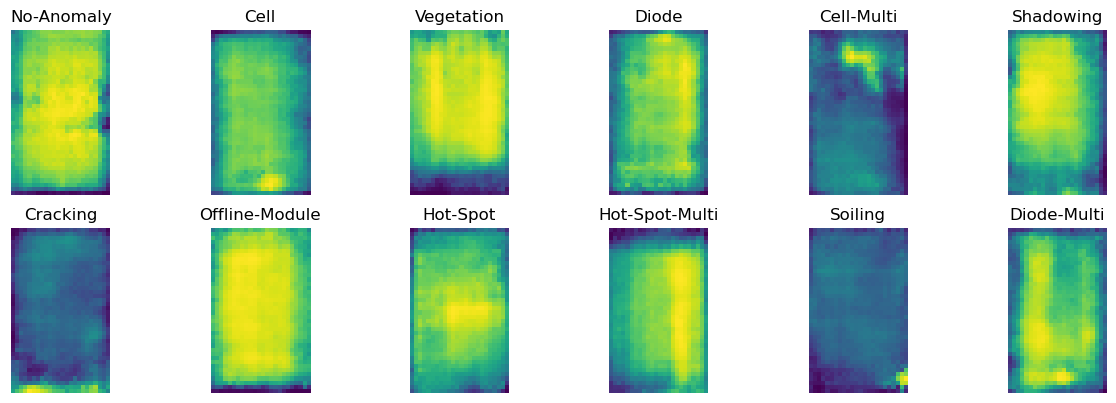

[Epoch 431/500] [D loss: 0.293578177690506] [G loss: 8.8405122756958]
[Epoch 432/500] [D loss: 0.015224596485495567] [G loss: 4.989527702331543]
[Epoch 433/500] [D loss: 0.002660645404830575] [G loss: 10.916346549987793]
[Epoch 434/500] [D loss: 0.00264987931586802] [G loss: 5.869446277618408]
[Epoch 435/500] [D loss: 4.4395917939255014e-05] [G loss: 9.188520431518555]
[Epoch 436/500] [D loss: 0.019590120762586594] [G loss: 7.554354667663574]
[Epoch 437/500] [D loss: 0.0016295247478410602] [G loss: 6.95267391204834]
[Epoch 438/500] [D loss: 0.002270975848659873] [G loss: 6.009268760681152]
[Epoch 439/500] [D loss: 0.0028953307773917913] [G loss: 6.099850177764893]
[Epoch 440/500] [D loss: 0.02707538940012455] [G loss: 8.08332633972168]


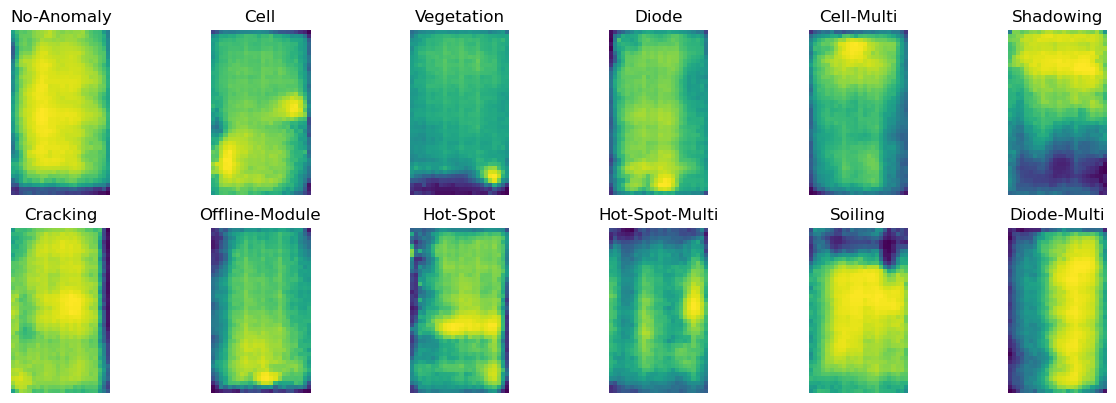

[Epoch 441/500] [D loss: 0.08192464709281921] [G loss: 9.841814041137695]
[Epoch 442/500] [D loss: 0.07231874018907547] [G loss: 8.583917617797852]
[Epoch 443/500] [D loss: 0.01905854418873787] [G loss: 5.748186111450195]
[Epoch 444/500] [D loss: 0.005155257415026426] [G loss: 5.085850238800049]
[Epoch 445/500] [D loss: 0.0037874928675591946] [G loss: 5.008633136749268]
[Epoch 446/500] [D loss: 0.007429548539221287] [G loss: 6.408219814300537]
[Epoch 447/500] [D loss: 0.007570056710392237] [G loss: 4.639440536499023]
[Epoch 448/500] [D loss: 0.005888999905437231] [G loss: 5.698757171630859]
[Epoch 449/500] [D loss: 0.024938469752669334] [G loss: 5.279898643493652]
[Epoch 450/500] [D loss: 0.0016996226040646434] [G loss: 5.8103508949279785]


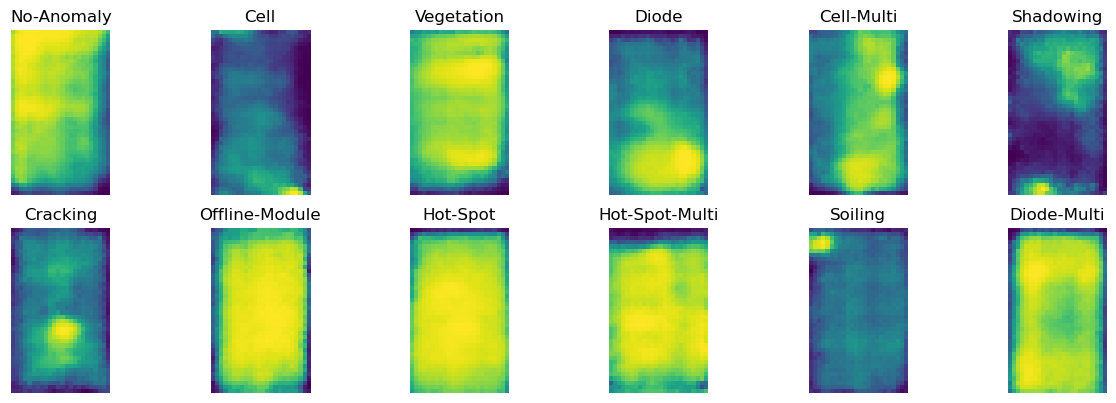

[Epoch 451/500] [D loss: 1.3262653350830078] [G loss: 2.9561898708343506]
[Epoch 452/500] [D loss: 0.10333394259214401] [G loss: 8.851184844970703]
[Epoch 453/500] [D loss: 0.008192155510187149] [G loss: 4.872067451477051]
[Epoch 454/500] [D loss: 0.010345445945858955] [G loss: 6.451298236846924]
[Epoch 455/500] [D loss: 0.001958173466846347] [G loss: 5.967173099517822]
[Epoch 456/500] [D loss: 0.004445937462151051] [G loss: 9.403936386108398]
[Epoch 457/500] [D loss: 0.00407236535102129] [G loss: 6.885521411895752]
[Epoch 458/500] [D loss: 0.04218319058418274] [G loss: 7.677560806274414]
[Epoch 459/500] [D loss: 0.0003304539422970265] [G loss: 7.299395561218262]
[Epoch 460/500] [D loss: 0.019612250849604607] [G loss: 5.91835355758667]


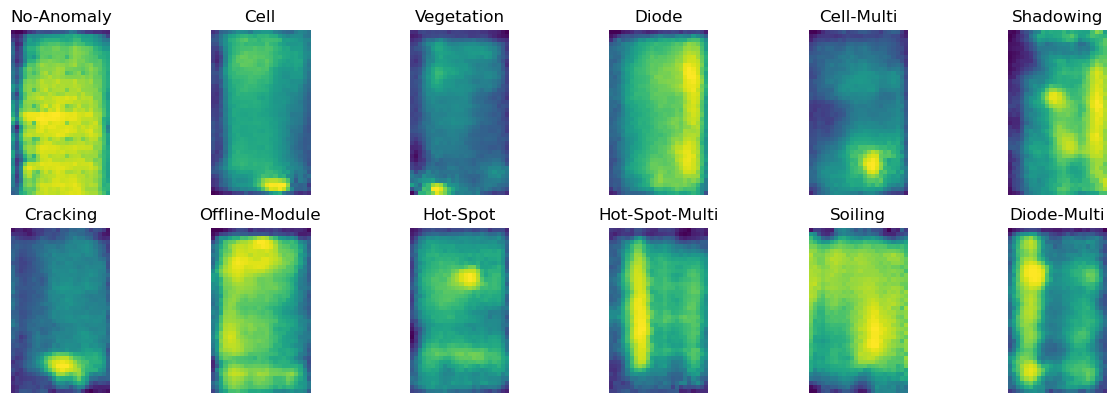

[Epoch 461/500] [D loss: 0.02628711797297001] [G loss: 4.4701738357543945]
[Epoch 462/500] [D loss: 0.010945356450974941] [G loss: 6.3014349937438965]
[Epoch 463/500] [D loss: 0.00268073589541018] [G loss: 5.4108781814575195]
[Epoch 464/500] [D loss: 0.04743846505880356] [G loss: 10.54142951965332]
[Epoch 465/500] [D loss: 0.0033119244035333395] [G loss: 5.966846466064453]
[Epoch 466/500] [D loss: 0.011082186363637447] [G loss: 5.762089729309082]
[Epoch 467/500] [D loss: 0.0035909893922507763] [G loss: 5.188092231750488]
[Epoch 468/500] [D loss: 0.0034838602878153324] [G loss: 11.760644912719727]
[Epoch 469/500] [D loss: 0.0011698807356879115] [G loss: 6.03975248336792]
[Epoch 470/500] [D loss: 0.001597108319401741] [G loss: 6.639697074890137]


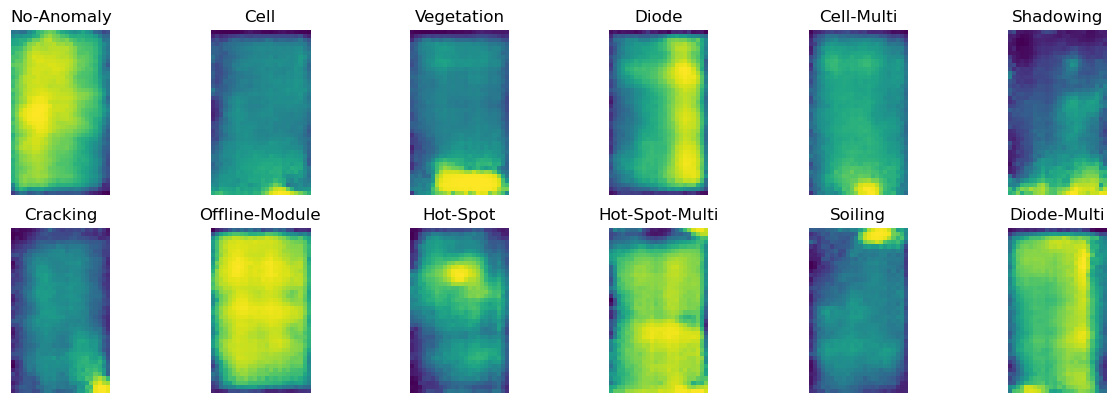

[Epoch 471/500] [D loss: 0.01744232140481472] [G loss: 8.896331787109375]
[Epoch 472/500] [D loss: 0.007519543636590242] [G loss: 9.951741218566895]
[Epoch 473/500] [D loss: 0.01251605711877346] [G loss: 6.908512115478516]
[Epoch 474/500] [D loss: 0.00436905212700367] [G loss: 6.912467002868652]
[Epoch 475/500] [D loss: 1.6528181731700897e-05] [G loss: 10.491336822509766]
[Epoch 476/500] [D loss: 0.0028530354611575603] [G loss: 5.497725009918213]
[Epoch 477/500] [D loss: 0.012228614650666714] [G loss: 5.070651054382324]
[Epoch 478/500] [D loss: 0.012091496959328651] [G loss: 5.307797431945801]
[Epoch 479/500] [D loss: 0.002129302127286792] [G loss: 6.227268218994141]
[Epoch 480/500] [D loss: 0.0006738444208167493] [G loss: 6.767892360687256]


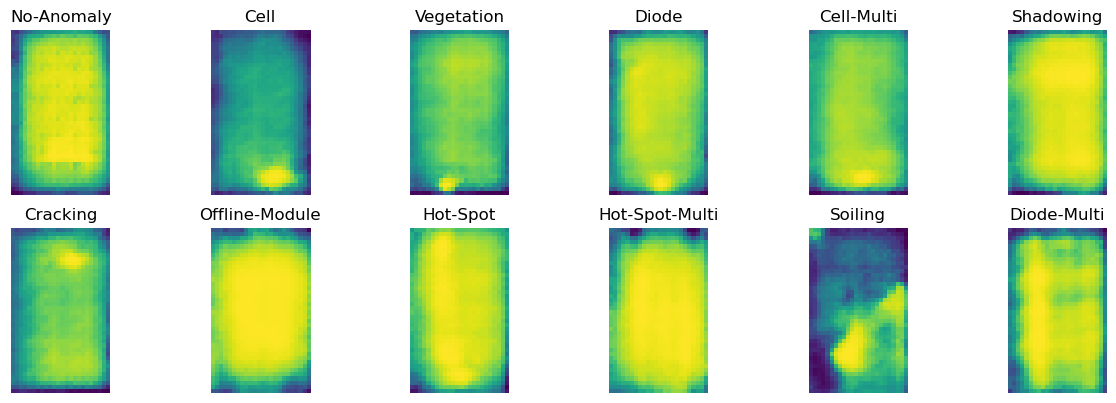

[Epoch 481/500] [D loss: 0.0016340451547876] [G loss: 5.654365539550781]
[Epoch 482/500] [D loss: 0.009045703336596489] [G loss: 4.504477500915527]
[Epoch 483/500] [D loss: 0.005787519738078117] [G loss: 4.996077537536621]
[Epoch 484/500] [D loss: 0.013803916051983833] [G loss: 6.703119277954102]
[Epoch 485/500] [D loss: 0.005446529481559992] [G loss: 5.226861476898193]
[Epoch 486/500] [D loss: 0.0056535908952355385] [G loss: 5.457860946655273]
[Epoch 487/500] [D loss: 0.003696383675560355] [G loss: 7.3242645263671875]
[Epoch 488/500] [D loss: 0.02664199471473694] [G loss: 8.28740406036377]
[Epoch 489/500] [D loss: 0.0044641499407589436] [G loss: 5.253276824951172]
[Epoch 490/500] [D loss: 0.009568428620696068] [G loss: 5.92158317565918]


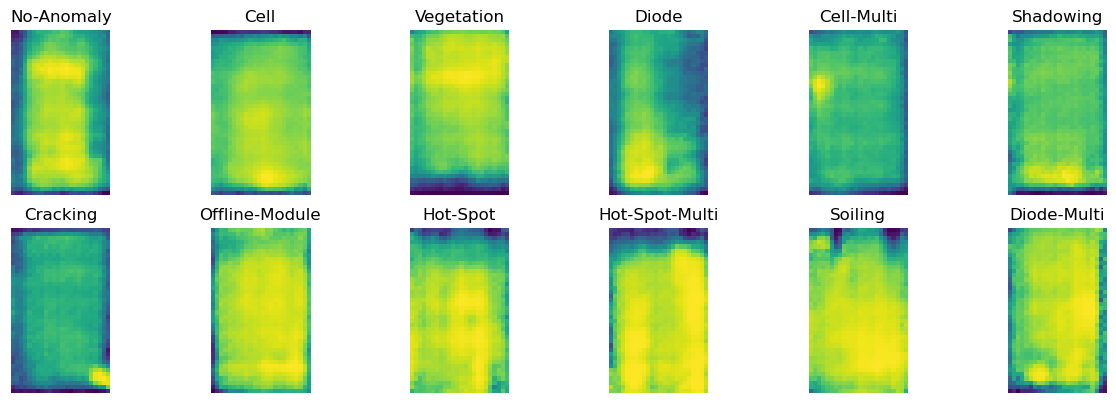

[Epoch 491/500] [D loss: 0.010835575871169567] [G loss: 6.782798767089844]
[Epoch 492/500] [D loss: 0.004448396153748035] [G loss: 6.720765113830566]
[Epoch 493/500] [D loss: 0.009671040810644627] [G loss: 5.144067764282227]
[Epoch 494/500] [D loss: 0.013449289835989475] [G loss: 4.818542003631592]
[Epoch 495/500] [D loss: 0.00388866919092834] [G loss: 5.340125560760498]
[Epoch 496/500] [D loss: 0.00886472687125206] [G loss: 7.2269415855407715]
[Epoch 497/500] [D loss: 0.00034068195964209735] [G loss: 7.279302597045898]
[Epoch 498/500] [D loss: 0.009410210885107517] [G loss: 4.7076592445373535]
[Epoch 499/500] [D loss: 0.00302883330732584] [G loss: 5.328029632568359]


In [14]:
g_model.fit(g_train_test.train_dataloader)

In [15]:
def preprocess_gan_agument(image, aug_number, label):
    image_list = []
    if aug_number == 0:
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image = (image - 127.5) / 127.5
        image = image[np.newaxis]
        image_list.append(image)
    else:
        for _ in range(aug_number):
            img_aug = g_model.augment(1, solar_dataset.classes_list.index(label))
            for i in img_aug:
                image_list.append(i.cpu().numpy())            
    return image_list

In [16]:
input_dim = (1, 40, 24)
output_dim = solar_dataset.num_classes
our_model_gan = PaperClassificator(input_dim, output_dim).to(device)
print(summary(our_model_gan, (1, input_dim[0], input_dim[1], input_dim[2])))
our_loss_gan = nn.BCELoss()
our_optimizer_gan = Adam(our_model_gan.parameters(), lr=0.0001)
our_train_test_gan = utils.TrainTest(
    our_model_gan,
    our_loss_gan,
    32,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_gan_agument,
    augment=True,
)

Layer (type:depth-idx)                   Output Shape              Param #
PaperClassificator                       [1, 12]                   --
├─Sequential: 1-1                        [1, 12]                   --
│    └─Conv2d: 2-1                       [1, 80, 40, 24]           800
│    └─ReLU: 2-2                         [1, 80, 40, 24]           --
│    └─MaxPool2d: 2-3                    [1, 80, 20, 12]           --
│    └─BatchNorm2d: 2-4                  [1, 80, 20, 12]           160
│    └─Conv2d: 2-5                       [1, 160, 20, 12]          115,360
│    └─ReLU: 2-6                         [1, 160, 20, 12]          --
│    └─MaxPool2d: 2-7                    [1, 160, 10, 6]           --
│    └─BatchNorm2d: 2-8                  [1, 160, 10, 6]           320
│    └─Conv2d: 2-9                       [1, 320, 10, 6]           461,120
│    └─ReLU: 2-10                        [1, 320, 10, 6]           --
│    └─MaxPool2d: 2-11                   [1, 320, 5, 3]            --
│ 

Best Epoch # 0  Validation Loss= 0.14408068358898163  Validation Accu= 0.6486402000625195
Best Epoch # 1  Validation Loss= 0.1208280473947525  Validation Accu= 0.705532979055955
Best Epoch # 3  Validation Loss= 0.12300645560026169  Validation Accu= 0.7064707721162864
Best Epoch # 4  Validation Loss= 0.12020057439804077  Validation Accu= 0.718974679587371
Best Epoch # 5  Validation Loss= 0.11168529093265533  Validation Accu= 0.7527352297592997
Best Epoch # 7  Validation Loss= 0.11273407936096191  Validation Accu= 0.7636761487964989
Best Epoch # 8  Validation Loss= 0.11305554956197739  Validation Accu= 0.7758674585808065
Best Epoch # 9  Validation Loss= 0.11319709569215775  Validation Accu= 0.7811816192560175
Best Epoch # 23  Validation Loss= 0.17342190444469452  Validation Accu= 0.7827446076899031
Best Epoch # 52  Validation Loss= 0.23792602121829987  Validation Accu= 0.7843075961237886
Best Epoch # 71  Validation Loss= 0.3217242658138275  Validation Accu= 0.7974366989684276


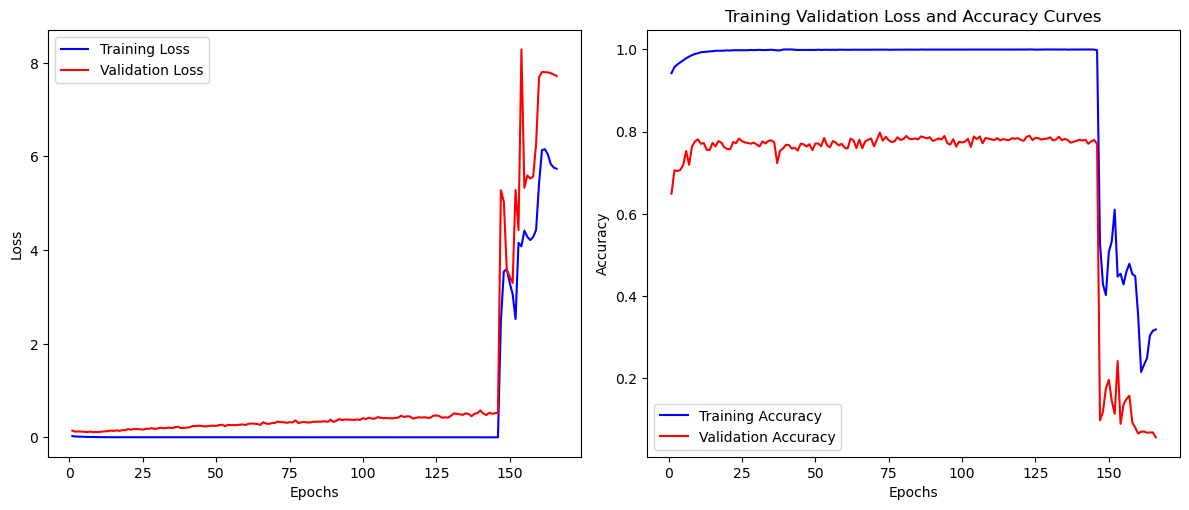

In [17]:
# Train Model
our_best_gan_loss, our_best_gan_accuracy, our_best_gan_epoch = our_train_test_gan.train(our_optimizer_gan, 166, "our_model_gan.pth")

Loss = 7.724067073792219   Accuracy= 0.0425


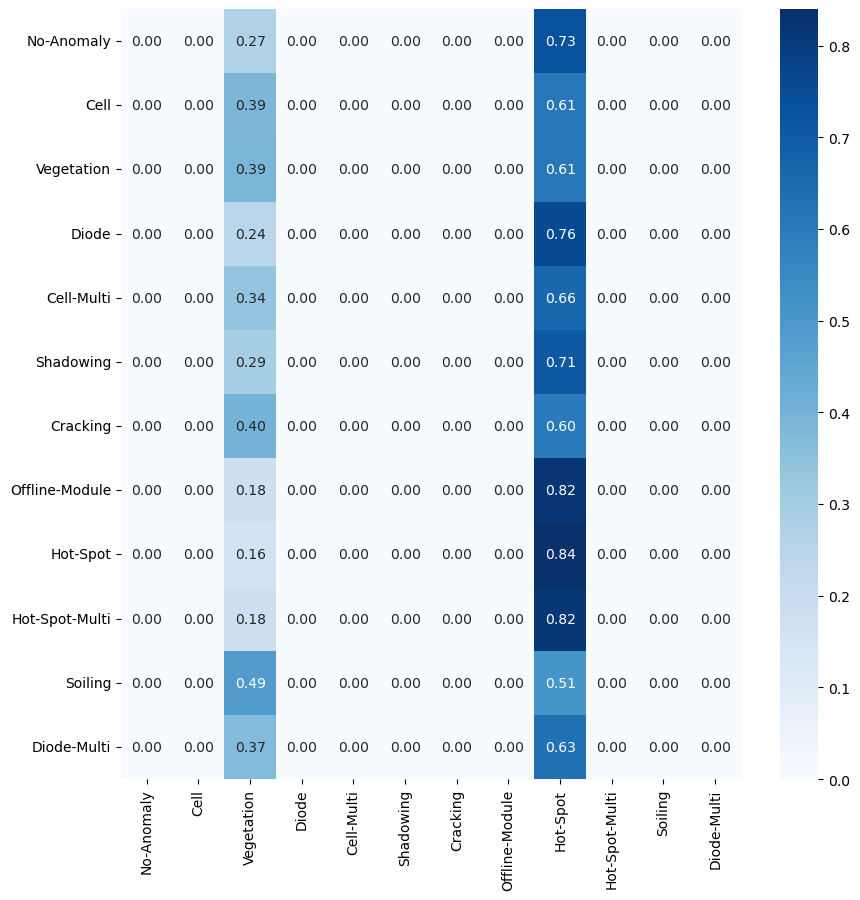

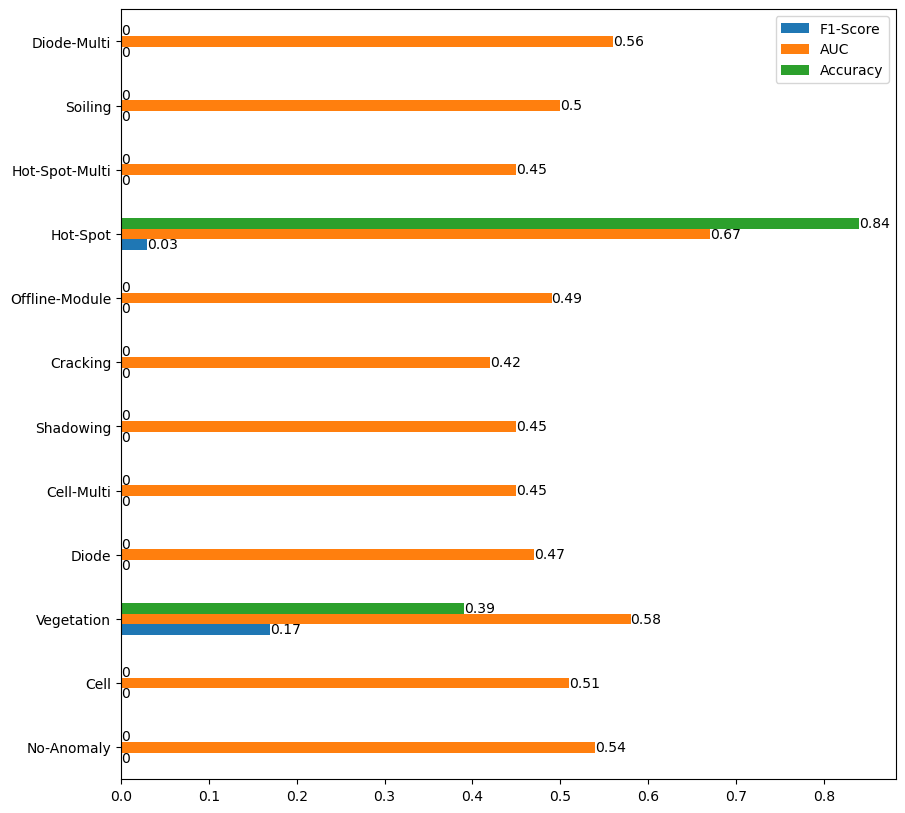

In [18]:
our_train_test_gan.test()
our_train_test_gan.plot_confusion_matrix()
our_train_test_gan.plot_class_metrics()

---

# Pre-Trained Models

In computer vision, transfer learning is commonly used with convolutional neural networks (CNNs) pre-trained on large image datasets like ImageNet. These pre-trained models can be used as a fixed feature extractor for tasks such as object detection, image segmentation, and image classification.

After running our models we decided to use pre trained models:


*   Resnet18
*   Visual Transformers
<br><br>

The use of pre trained models in deep learning has some advantages such as:

**Reducing the training time** - since this models are already trained on large and diverse datasets like ImageNet they've learned rich feature representations.

**Less Labeled Data Required** -  they can perform well with smaller amounts of labeled data for the target task. This is crucial in scenarios where collecting large labeled datasets is time-consuming or expensive.

**Resource Savings**: Training deep neural networks from scratch requires significant computational resources. By using pre-trained models, we can save time, computing power, and energy consumption.

**Feature Retention through Freezing**: One of the key steps in transfer learning is the ability to freeze the layers of the pre-trained model so that only some portions of the network are updated during training. Freezing is crucial to maintain the features that the pre-trained model has already learned.

<br><br>

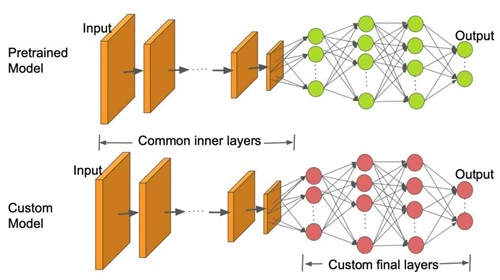

<br><br>

The image above ilustrates well one of the keys points for using pre-trained models in this project. The possibility of changeing the existing archisture of the model - we can freeze most of the parameters and use/change the others. Unfreezing a layer means that the weights and biases of that layer will be updated during the training process.



# Pretrained ResNET 18

ResNet18 is a relatively lightweight convolutional neural network (CNN) compared to deeper architectures like ResNet50 or ResNet101. For tasks with limited computational resources or not extremely complex this model offers a good balance between complexity and performance. Due to its smallers size, compared with the other models, it requires less time to train facilitating easy experimentation with different architectures or hyperparameters within a reasonable time frame. It is also resource efficient in terms of memory and computation.
<br><br>
For this task we start to freeze all the parameters.
Then we unfreeze the last layer and change the number of classes in the output, the default was 10 and we increase it to 12 (our dataset classes).
Unfreezing the last layer means allowing the weights and biases of that specific layer to be updated during the training process, improve the model performance and adapting it to new labels.
The learning rate for the optimizer was also updated, while the rest of the model is running with a learning rate of 0.0001, the fourth layer is 0.001.


In [59]:
def preprocess_resnet(image, aug_number=0, label=None):
    image_list = []

    # Define transformations for augmentation
    transforms_list = [
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.15),
            transforms.RandomVerticalFlip(p=0.15),
            #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            #transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.21),
            #transforms.ToTensor(),
            #transforms.Normalize(mean=(0.5652, 0.5652, 0.5652), std=(0.5, 0.5, 0.5)),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    ]

    # Define plain forward
    transforms_plain = [
        transforms.Compose([
            #transforms.ToPILImage(),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    ]

    if aug_number == 0:
        image_list.append(transforms_plain[0](Image.fromarray(image)).numpy())
    else:
        for _ in range(aug_number):
            img_aug = transforms_list[0](Image.fromarray(image)).numpy()
            image_list.append(img_aug)

    return image_list

In [60]:
input_dim = (3, 40, 24)
model_resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
for p in model_resnet.parameters():
    p.requires_grad = False
for p in model_resnet.fc.parameters():
    p.requires_grad = True
for p in model_resnet.layer4.parameters():
    p.requires_grad = True
for p in model_resnet.layer3.parameters():
    p.requires_grad = True

# Replace last layer
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 12)

print(summary(model_resnet.to(device), (1, input_dim[0], input_dim[1], input_dim[2])))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 12]                   --
├─Conv2d: 1-1                            [1, 64, 20, 12]           (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 20, 12]           (128)
├─ReLU: 1-3                              [1, 64, 20, 12]           --
├─MaxPool2d: 1-4                         [1, 64, 10, 6]            --
├─Sequential: 1-5                        [1, 64, 10, 6]            --
│    └─BasicBlock: 2-1                   [1, 64, 10, 6]            --
│    │    └─Conv2d: 3-1                  [1, 64, 10, 6]            (36,864)
│    │    └─BatchNorm2d: 3-2             [1, 64, 10, 6]            (128)
│    │    └─ReLU: 3-3                    [1, 64, 10, 6]            --
│    │    └─Conv2d: 3-4                  [1, 64, 10, 6]            (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 10, 6]            (128)
│    │    └─ReLU: 3-6                    [1, 64, 10, 6]    

Using cache found in C:\Users\catia/.cache\torch\hub\pytorch_vision_v0.10.0
c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [61]:
#Changing the learning rate
loss_resnet = nn.CrossEntropyLoss().to(device)
optimizer_resnet = SGD([
    {'params': model_resnet.layer3.parameters(), 'lr': 0.001},
    {'params': model_resnet.layer4.parameters(), 'lr': 0.001},
    {'params': model_resnet.fc.parameters(), 'lr': 0.0001},
], momentum=0.9)
train_test_resnet = utils.TrainTest(
    model_resnet,
    loss_resnet,
    32,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_resnet,
    augment=False,
)

Best Epoch # 0  Validation Loss= 1.2672040462493896  Validation Accu= 0.6083150984682714
Best Epoch # 1  Validation Loss= 1.1296226978302002  Validation Accu= 0.6492653954360738
Best Epoch # 2  Validation Loss= 1.0660110712051392  Validation Accu= 0.6661456705220381
Best Epoch # 3  Validation Loss= 1.039676308631897  Validation Accu= 0.6742732103782432
Best Epoch # 4  Validation Loss= 1.0055744647979736  Validation Accu= 0.681775554860894
Best Epoch # 6  Validation Loss= 1.0348912477493286  Validation Accu= 0.6820881525476712
Best Epoch # 7  Validation Loss= 1.0377229452133179  Validation Accu= 0.6874023132228821
Best Epoch # 10  Validation Loss= 1.1356780529022217  Validation Accu= 0.6886527039699907
Best Epoch # 126  Validation Loss= 1.7267712354660034  Validation Accu= 0.6895904970303219
Best Epoch # 136  Validation Loss= 1.7039263248443604  Validation Accu= 0.6927164738980931


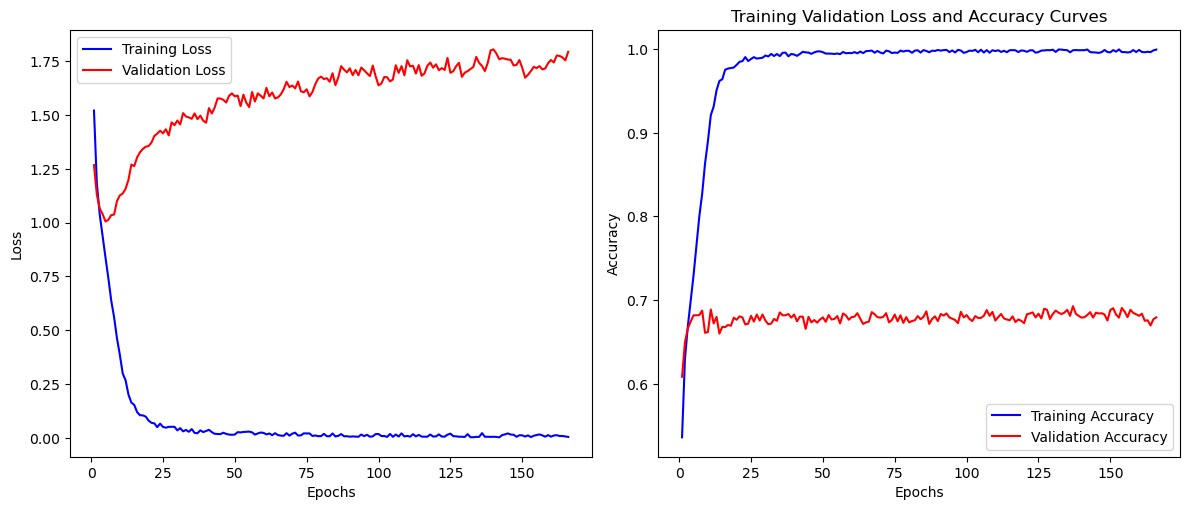

In [62]:
# Train Model
our_best_resnet_loss, our_best_resnet_accuracy, our_best_resnet_epoch = train_test_resnet.train(optimizer_resnet, 166, "resnet_model_aug.pth")

In [15]:
train_test_resnet.test()
train_test_resnet.plot_confusion_matrix()
train_test_resnet.plot_class_metrics()

OutOfMemoryError: CUDA out of memory. Tried to allocate 11.96 GiB. GPU 0 has a total capacty of 12.00 GiB of which 0 bytes is free. Of the allocated memory 16.57 GiB is allocated by PyTorch, and 5.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Pretrained Transformer

In [16]:
def preprocess_vit(image, aug_number=0, label=None):
    image_list = []

    # Define transformations for augmentation
    transforms_list = [
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.15),
            transforms.RandomVerticalFlip(p=0.15),
            #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            #transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.21),
            #transforms.ToTensor(),
            #transforms.Normalize(mean=(0.5652, 0.5652, 0.5652), std=(0.5, 0.5, 0.5)),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    ]

    # Define plain forward
    transforms_plain = [
        transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    ]

    if aug_number == 0:
        image_list.append(transforms_plain[0](Image.fromarray(image)).numpy())
    else:
        for _ in range(aug_number):
            img_aug = transforms_list[0](Image.fromarray(image)).numpy()
            image_list.append(img_aug)

    return image_list

In [29]:
input_dim = (3, 224, 224)
weights_vit = torchvision.models.ViT_B_16_Weights.DEFAULT
model_vit = torchvision.models.vit_b_16(weights=weights_vit)
for p in model_vit.parameters():
    p.requires_grad = False

heads_vit = nn.Sequential(nn.Linear(in_features=768, out_features=12, bias=True))
model_vit.heads = heads_vit

summary(model_vit, input_size=(1, input_dim[0], input_dim[1], input_dim[2]))

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 12]                   768
├─Conv2d: 1-1                                 [1, 768, 14, 14]          (590,592)
├─Encoder: 1-2                                [1, 197, 768]             151,296
│    └─Dropout: 2-1                           [1, 197, 768]             --
│    └─Sequential: 2-2                        [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-

In [30]:
loss_vit = nn.CrossEntropyLoss()
optimizer_vit = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model_vit.parameters()),
    lr=0.0001)
train_test_vit = utils.TrainTest(
    model_vit,
    loss_vit,
    32,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_vit,
    augment=False,
)

In [31]:
# Train Model
our_best_vit_loss, our_best_vit_accuracy, our_best_vit_epoch = train_test_vit.train(optimizer_vit, 10, "resnet_model_vit.pth")

KeyboardInterrupt: 

# Results and discussion

TBD

# Conclusions

TBD

# References

https://www.sciencedirect.com/science/article/pii/S0263224123006991?via%3Dihub

https://arxiv.org/abs/2103.15158

https://arxiv.org/pdf/2010.11929.pdf